# Overview:

This will be the main notebook for analyzing and visualizing test_v5 results

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time

from pathlib import Path

import geopandas as gpd

import yaml

import matplotlib.colors as mcolors

In [3]:
from utils.analysis import fig_to_pil, write_mp4

$$ $$

# Create a function to run the full test.

- Print out config
- Print out completion rate and counts
- Generate zone map of taxi rejections

In [4]:
def make_zone_count_plot(locationIDs, log_scale=False, count_name="count ", print_nums=True):
    
    counts = (
        locationIDs.dropna().value_counts()
                   .rename_axis('LocationID')
                   .rename('n')
                   .reset_index()
    )
    
    zones = gpd.read_file("data/2023 yellow taxi/taxi_zones/taxi_zones.shp")
    zones = zones.merge(counts, on='LocationID', how="left")
    zones["n"] = zones["n"].fillna(0).astype(int)
    
    if log_scale:
        zones["log_n"] = np.log1p(zones["n"])
    
        fig, ax = plt.subplots(figsize=(10, 10))
        zones.plot(
            column="log_n",
            ax=ax,
            legend=True,
            linewidth=0.2,
            edgecolor="white",
        )
        ax.set_title(f"Log {count_name} by taxi zone")
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

        if print_nums:
            print(counts.sort_values("n", ascending=False).head(15))

    else:
        fig, ax = plt.subplots(figsize=(10, 10))
        zones.plot(
            column="n",
            ax=ax,
            legend=True,
            linewidth=0.2,
            edgecolor="white",
        )
        ax.set_title(f"{count_name} by taxi zone")
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

        if print_nums:
            print(counts.sort_values("n", ascending=False).head(15))




"""

Arguments:
 - test_folder
         string of relative path to test folder
 - log_rejections
         whether to use log scale in rejection plotting
 - unique_rejections
         whether to filter out unique pairs of (id, location) to prevent the same shift from
         continually making rejection requests from the same location

"""
def display_analysis(test_folder, info=None, log_rejections=False, unique_rejections=False, log_unfilled=False, log_below_thres=True, new_threshold=None, unique_thresholds=True):

    test_folder = Path(test_folder)

    print("loading data...", end="")

    primary_rejects_path = test_folder / "primary_rejects.parquet"
    secondary_rejects_path = test_folder / "secondary_rejects.parquet"
    unfilled_path = test_folder / "unfilled_trips.parquet"
    below_thres_path = test_folder / "below_thresholds.parquet"
    test_config_path = test_folder / "test_config.yaml"

    with open(test_config_path,'r') as f:
        config_dict = yaml.safe_load(f)
    
    primary_rejects_df  = pd.read_parquet(primary_rejects_path)
    secondary_rejects_df = pd.read_parquet(secondary_rejects_path)
    unfilled_df = pd.read_parquet(unfilled_path)
    below_df =    pd.read_parquet(below_thres_path)

    print("done")


    # primary rejects plot
    if unique_rejections:

        # filter out rows without unique combos
        print("Primary rejection rows before filtering:", len(primary_rejects_df))        
        unique_rejects_df = (primary_rejects_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Primary rejection rows after filtering:", len(unique_rejects_df))

        make_zone_count_plot(unique_rejects_df['location'], log_scale=log_rejections, count_name="Unique range rejections within same location")
        

    else:
        make_zone_count_plot(primary_rejects_df['location'], log_scale=log_rejections, count_name="Range rejections within same location")


    # secondary rejects plot
    if unique_rejections:

        # filter out rows without unique combos
        print("Secondary rejection rows before filtering:", len(secondary_rejects_df))        
        unique_rejects_df = (secondary_rejects_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Secondary rejection rows after filtering:", len(unique_rejects_df))

        make_zone_count_plot(unique_rejects_df['location'], log_scale=log_rejections, count_name="Unique range rejections to different location")
        

    else:
        make_zone_count_plot(secondary_rejects_df['location'], log_scale=log_rejections, count_name="Range rejections to different location")
    


    print("\n\n\n")


    make_zone_count_plot(unfilled_df['PU_LocationID'], log_scale=log_unfilled, count_name="Unfilled Trip Requests")
    print("\n\n\n")



    # apply new threshold if requested
    if new_threshold:
        print("Below threshold rows before new threshold:", len(below_df))      
        below_df = below_df[below_df['range'] <= new_threshold]
        print("Below threshold rows after new threshold:", len(below_df))

    if unique_thresholds:
        # filter out rows without unique combos
        print("Below threshold rows before unique filtering:", len(below_df))        
        unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Below threshold rows after unique filtering:", len(unique_below_df))

        
        make_zone_count_plot(unique_below_df['location'], log_scale=log_below_thres, count_name="Unique below range threshold events")


    else:
        
        make_zone_count_plot(below_df['location'], log_scale=log_below_thres, count_name="Below range threshold events")
    
    print("\n\n\n")
    
    pass

loading data...done


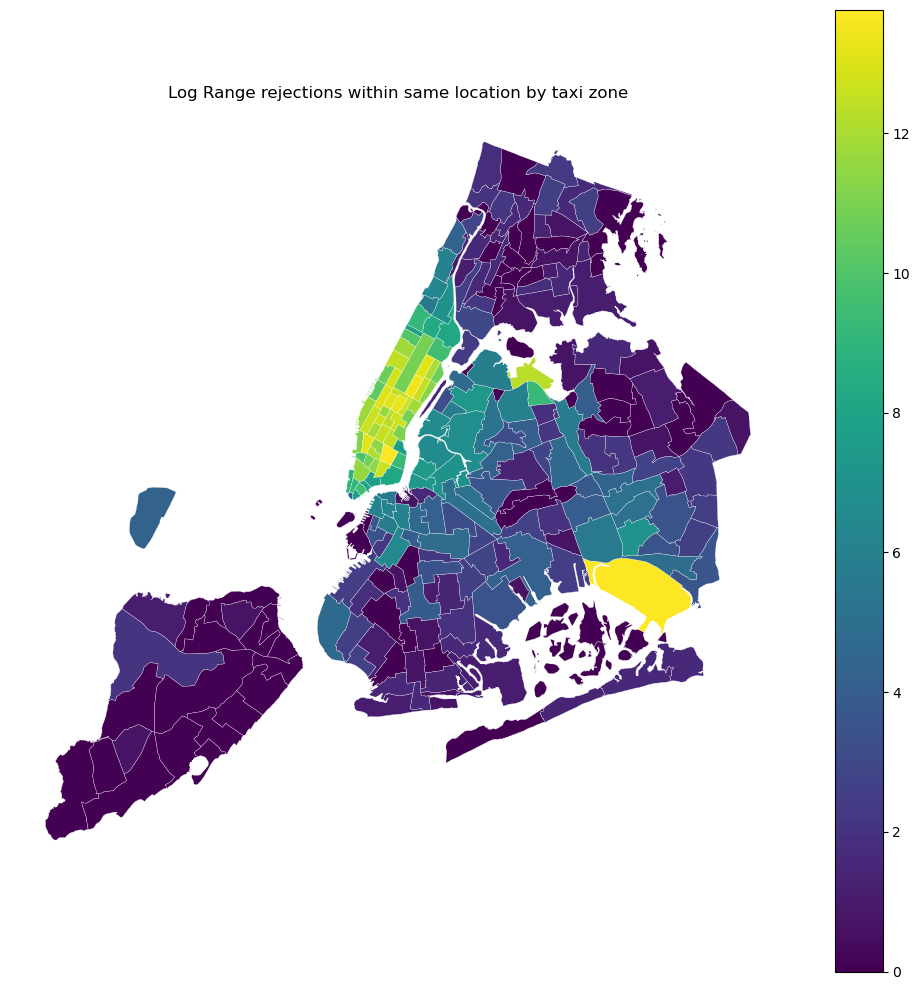

    LocationID       n
0         79.0  953872
1        132.0  909948
2        237.0  702719
3        161.0  598214
4        249.0  502812
5        236.0  502258
6        230.0  497398
7         48.0  486025
8        142.0  392088
9        186.0  338198
10       170.0  336112
11        68.0  321860
12       148.0  317017
13       162.0  316746
14       234.0  285677


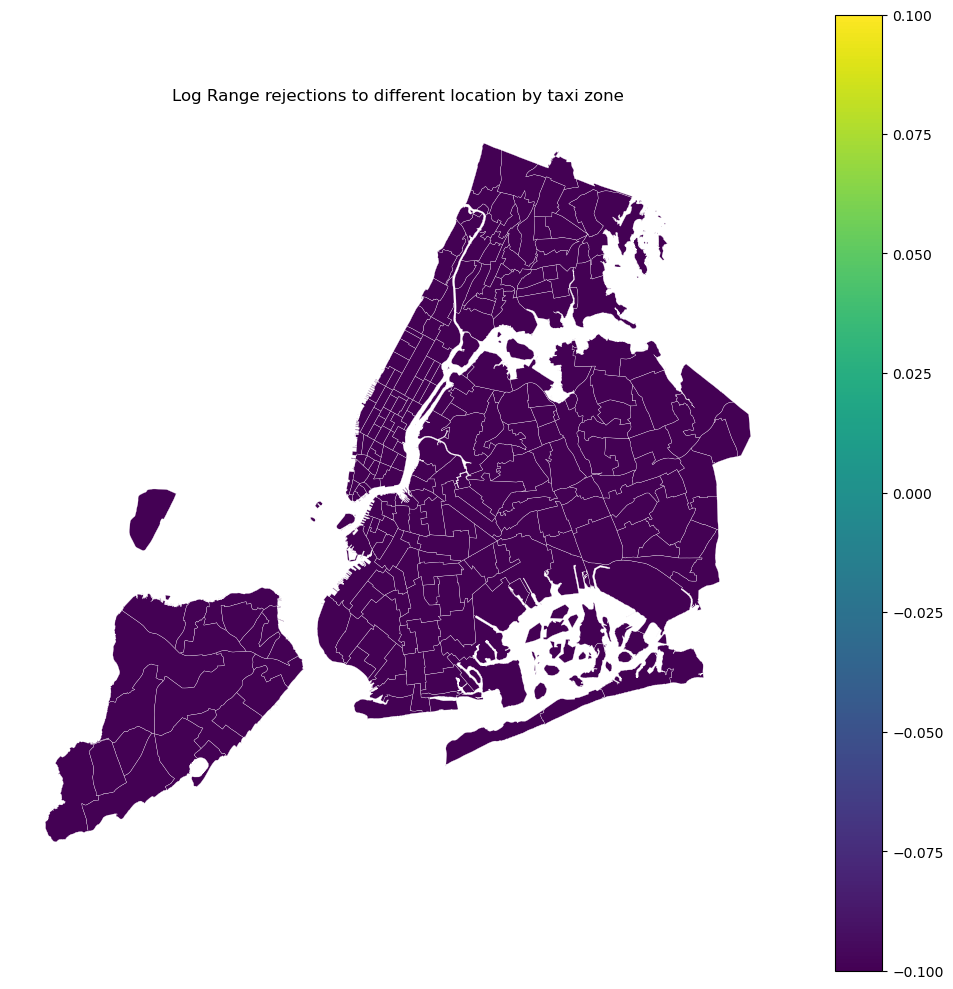

Empty DataFrame
Columns: [LocationID, n]
Index: []






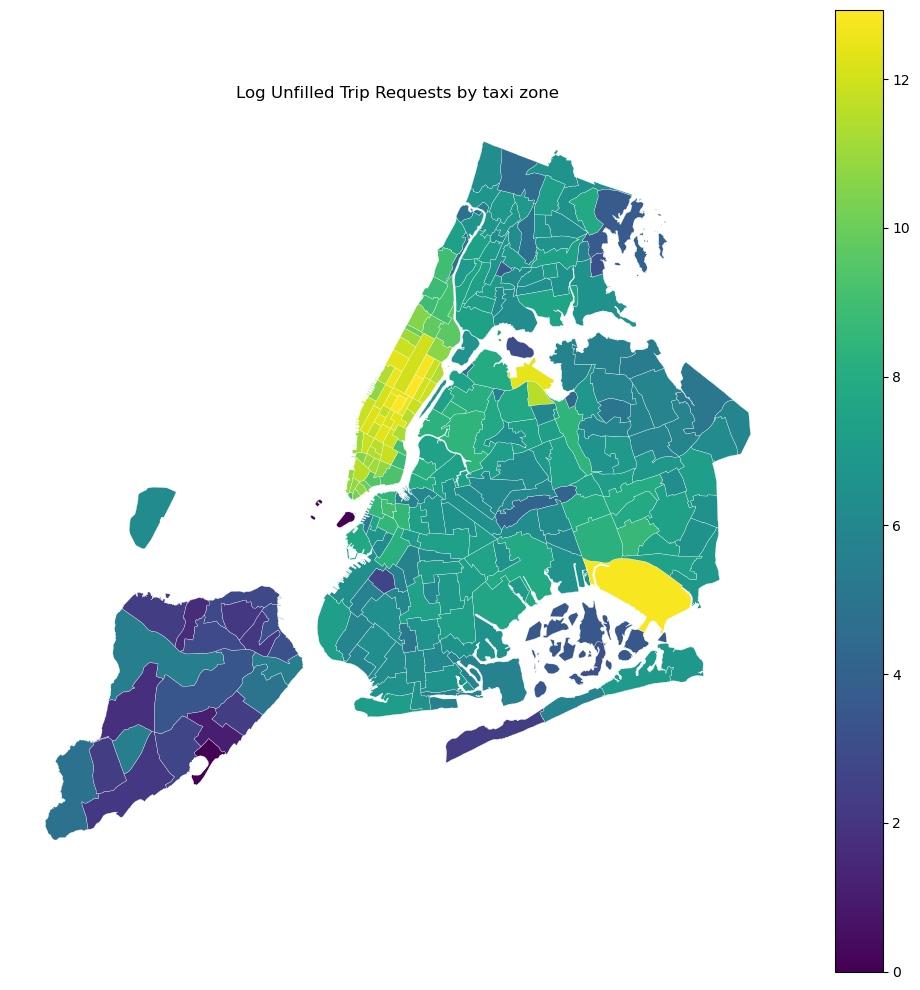

    LocationID       n
0          161  411914
1          237  409677
2          132  368607
3          236  344880
4          162  286452
5          142  285794
6          163  256545
7          230  256175
8          138  254122
9          186  232517
10         239  230581
11         170  230165
12         234  227233
13          68  205016
14         164  183770




Below threshold rows before new threshold: 1362759
Below threshold rows after new threshold: 823547
Below threshold rows before unique filtering: 823547
Below threshold rows after unique filtering: 778878


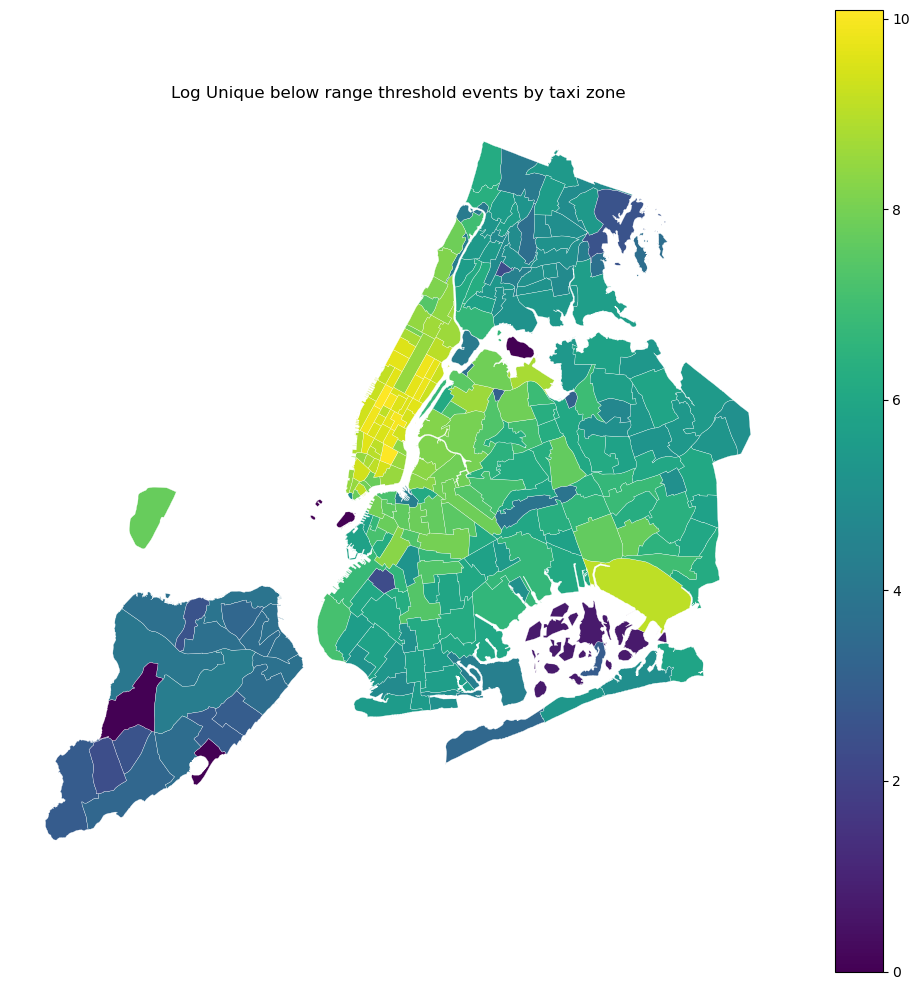

    LocationID      n
0           48  24190
1           79  23424
2          170  21044
3          230  20805
4           68  19500
5          236  18436
6          141  17965
7          107  17194
8          263  16314
9          164  16237
10         239  15903
11         237  15773
12         142  15550
13         249  15369
14         229  15288






In [5]:
display_analysis("test_v5/test_2/", unique_rejections=False, log_rejections=True, log_unfilled=True, new_threshold=20)

loading data...done


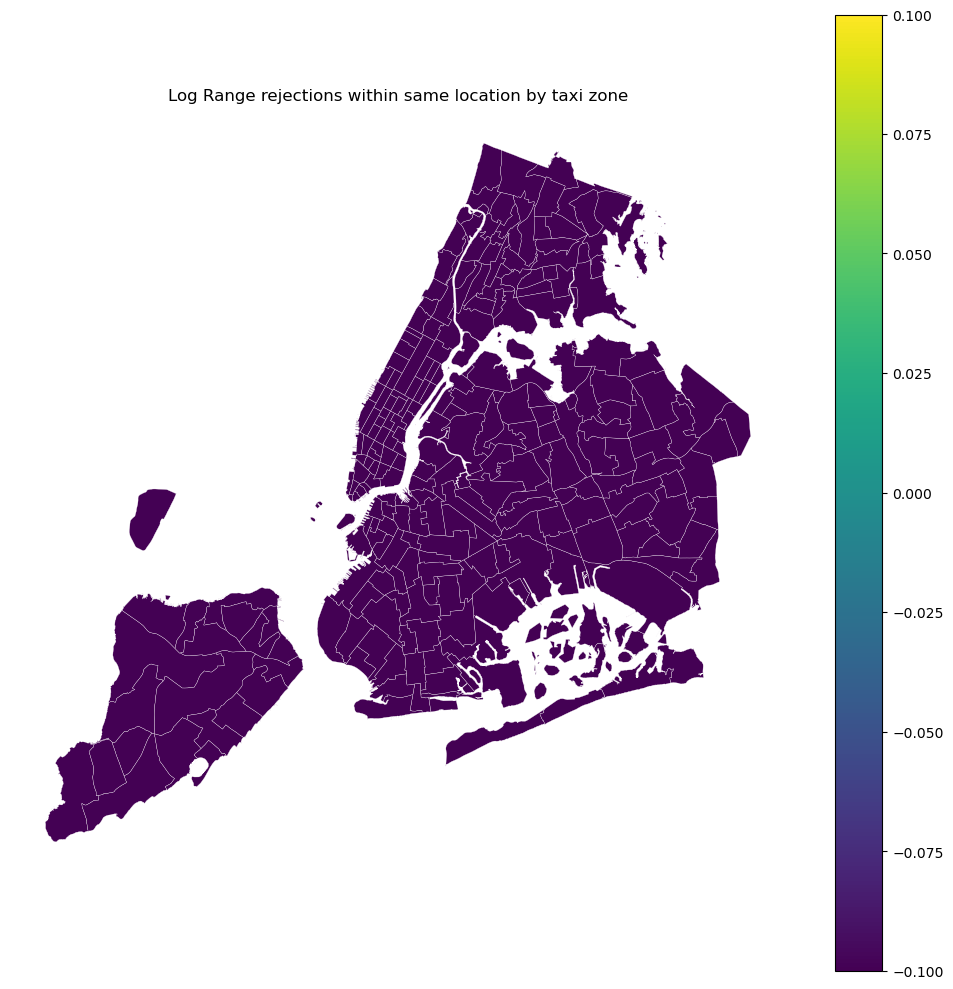

Empty DataFrame
Columns: [LocationID, n]
Index: []


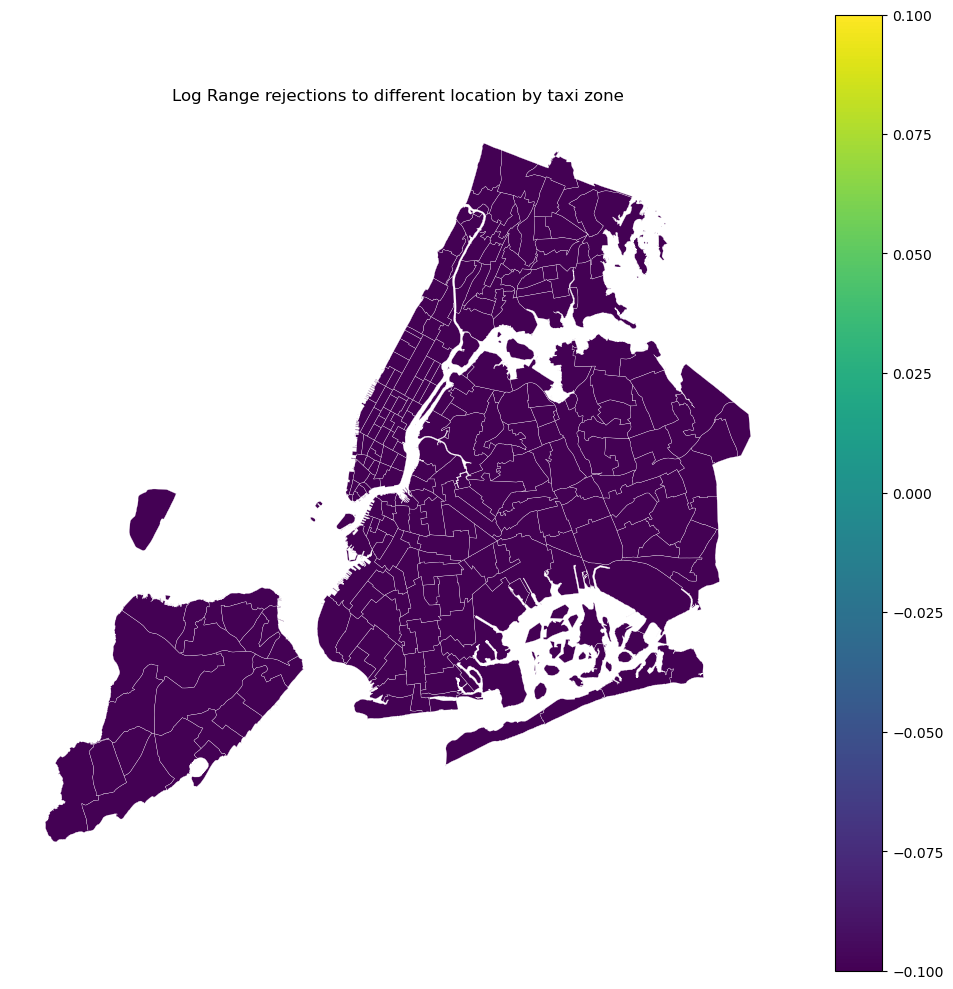

Empty DataFrame
Columns: [LocationID, n]
Index: []






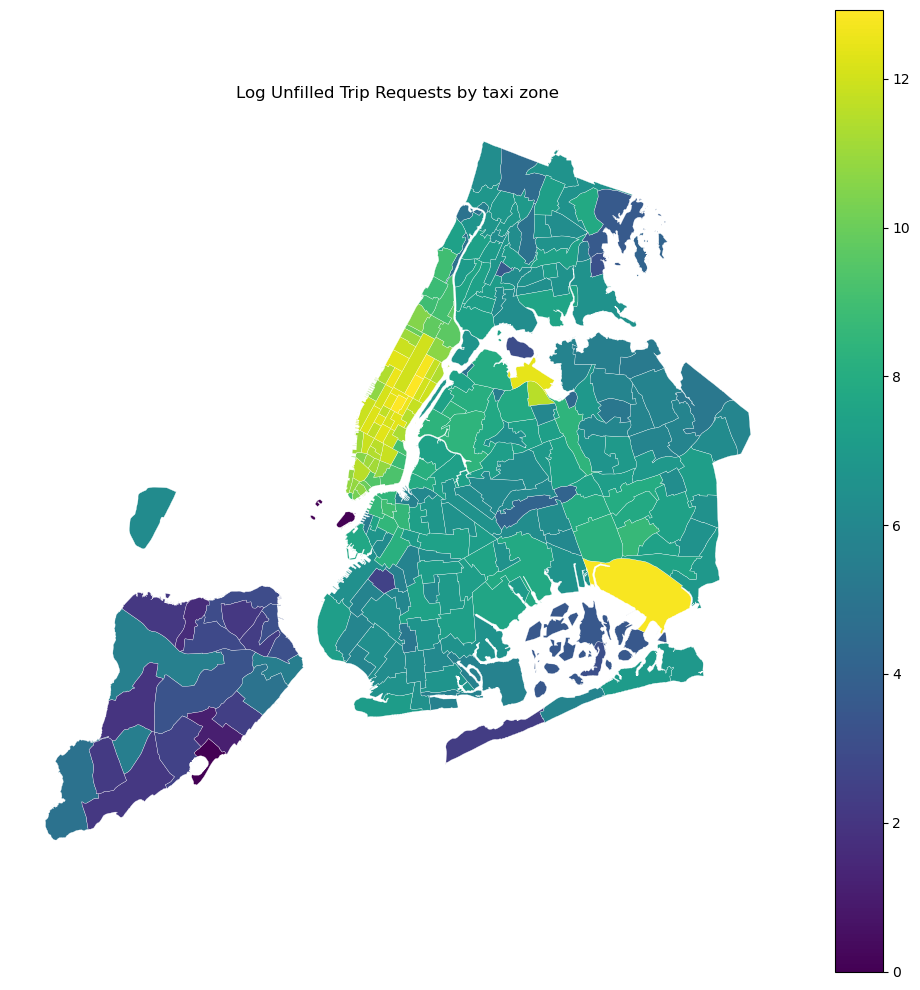

    LocationID       n
0          161  411206
1          237  408605
2          132  363379
3          236  344221
4          162  284630
5          142  284138
6          163  254982
7          230  254730
8          138  251154
9          186  230469
10         239  229675
11         170  228927
12         234  225646
13          68  203950
14         164  181776




Below threshold rows before new threshold: 1168717
Below threshold rows after new threshold: 665686
Below threshold rows before unique filtering: 665686
Below threshold rows after unique filtering: 636171


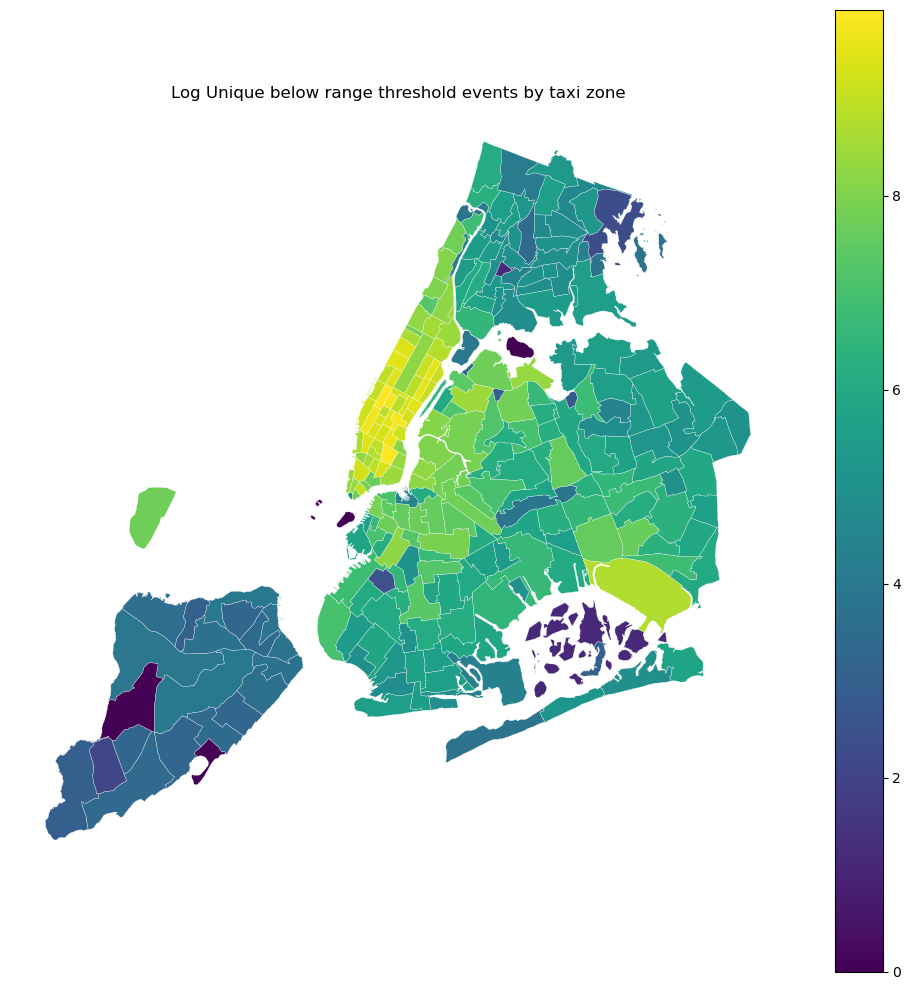

    LocationID      n
0           48  20224
1           79  20072
2          170  17402
3          230  17044
4           68  16243
5          107  14323
6          141  14211
7          164  13456
8          263  13291
9          239  12869
10         249  12616
11         229  12465
12         142  12096
13          90  11749
14         238  11472






In [6]:
display_analysis("test_v6/test_0/", unique_rejections=False, log_rejections=True, log_unfilled=True, new_threshold=20)

$$ $$

$$ $$

$$ $$

## Create dictionary of heatmaps of below range threshold occurances over days of the week and hour

In [17]:
all_dates_2023 = pd.date_range('2023-01-01', '2023-12-31', freq='D')
n_days_per_dow = all_dates_2023.dayofweek.value_counts().sort_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
n_days_per_dow.index = dow_labels

def create_location_event_heatmap(loc_df, loc_id, average):
    dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    heatmap_data = (
        loc_df
        .groupby(['dow_name', 'hour'])
        .size()
        .unstack(fill_value=0)
        .reindex(dow_labels)  # ensure Mon→Sun order
    )

    # divide by number of days of week if average
    if average:        
        # --- Convert counts to average events per day-of-week ---
        # Divide each dow row by the number of such days in 2023
        heatmap_data = heatmap_data.div(n_days_per_dow, axis=0)

    # 5) Plot with matplotlib
    plt.figure(figsize=(12, 4))
    im = plt.imshow(heatmap_data, aspect='auto')
    
    plt.xticks(range(24), range(24))               # hours 0–23
    plt.yticks(range(len(dow_labels)), dow_labels) # Mon–Sun
    
    cbar = plt.colorbar(im)

    if average:
        cbar.set_label('Average daily low-range events')
        plt.title(f'Average daily low-range events – Location {loc_id}')

    else:
        cbar.set_label('Count of low-range events')
        plt.title(f'Low-range events – Location {loc_id}')
    
    plt.xlabel('Hour of day')
    plt.ylabel('Day of week')
    plt.tight_layout()
    plt.show()



def below_threshold_heatmaps(test_folder, unique=False, new_threshold=None, top_n=10, average=False, before_min=0):
    test_folder = Path(test_folder)

    print("loading data...", end="")

    below_thres_path = test_folder / "below_thresholds.parquet"
    
    below_df = pd.read_parquet(below_thres_path)

    print("done")

    # apply before shift minimum if requested
    if before_min != None:
        below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
        
        print("Below threshold rows before new before shift minimum:", len(below_df))      
        below_df = below_df[below_df['till_end'] >= before_min]
        print("Below threshold rows after new before shift minimum:", len(below_df))

    # apply new threshold if requested
    if new_threshold:
        print("Below threshold rows before new threshold:", len(below_df))      
        below_df = below_df[below_df['range'] <= new_threshold]
        print("Below threshold rows after new threshold:", len(below_df))
        
    # filter out rows without unique combos
    if unique:
        print("Below threshold rows before unique filtering:", len(below_df))        
        unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Below threshold rows after unique filtering:", len(unique_below_df))



    
    # 2) Extract hour of day and day of week (0=Monday, 6=Sunday)
    below_df['hour'] = below_df['request_time'].dt.hour
    below_df['dow'] = below_df['request_time'].dt.dayofweek
    
    # Optional: map to names if you want labels later
    dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    below_df['dow_name'] = below_df['dow'].map(dict(enumerate(dow_labels)))


    # print top locs
    print(below_df['location'].value_counts().head(top_n))
    
    # grab top locs
    top_locs = below_df['location'].value_counts().head(top_n).index

    
    print("\n\n")

    for loc in top_locs:
        loc_df = below_df[below_df['location'] == loc]
    
        create_location_event_heatmap(loc_df, loc, average)


    

loading data...done
Below threshold rows before new before shift minimum: 1362759
Below threshold rows after new before shift minimum: 1052655
Below threshold rows before new threshold: 1052655
Below threshold rows after new threshold: 630995
location
79     21987
48     21374
170    18354
68     16857
230    16630
236    16375
141    15884
107    15258
237    14171
263    13970
Name: count, dtype: int64





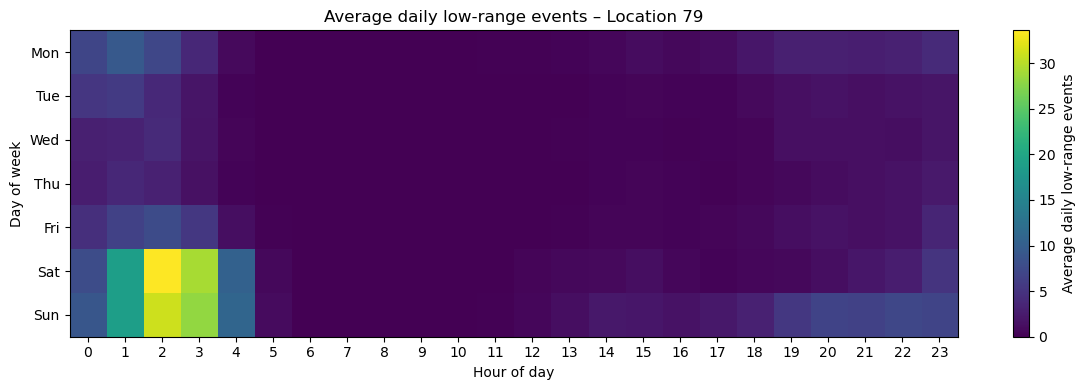

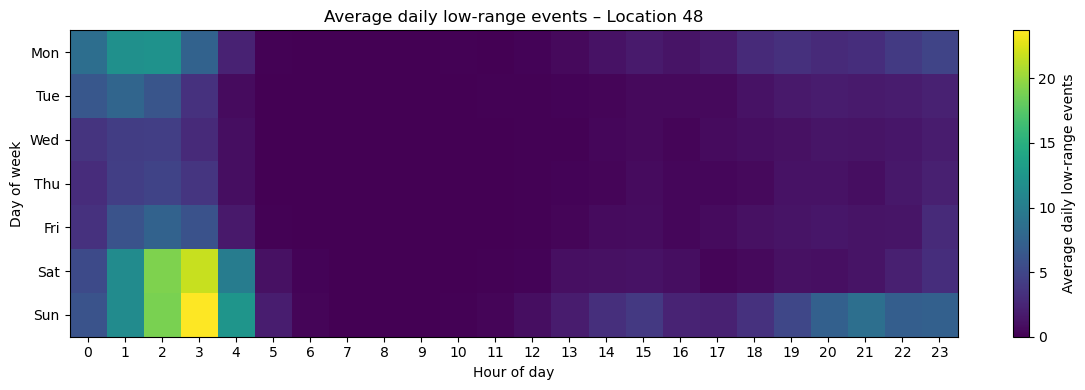

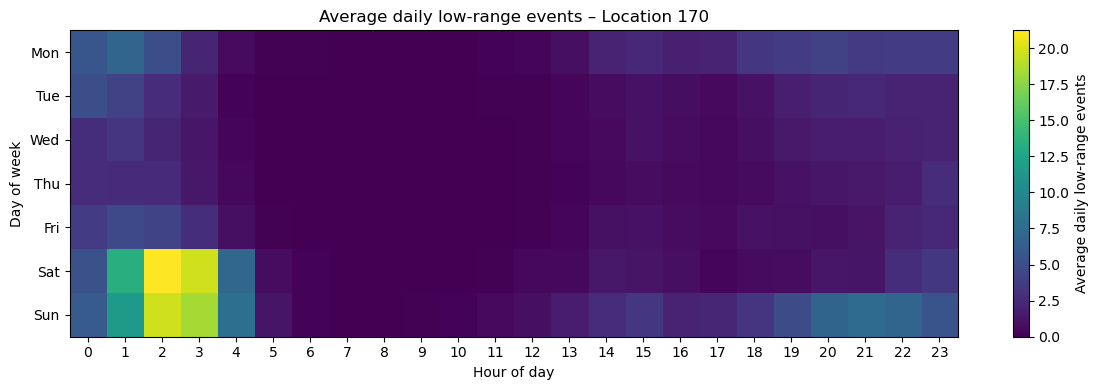

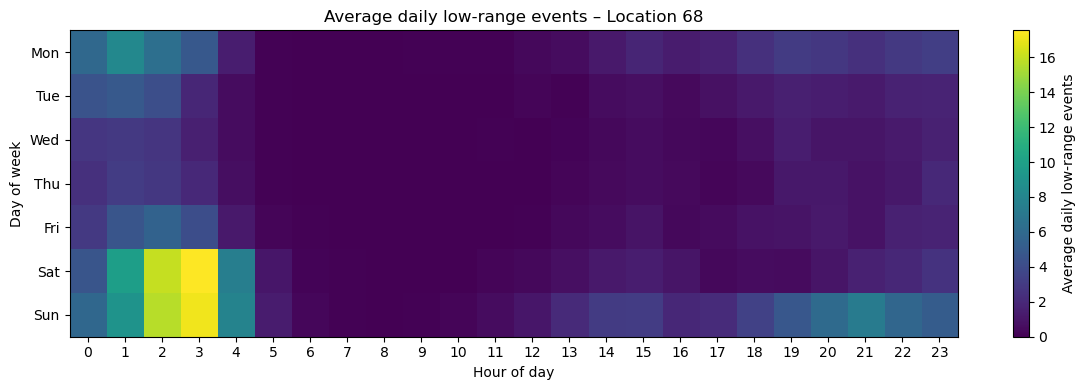

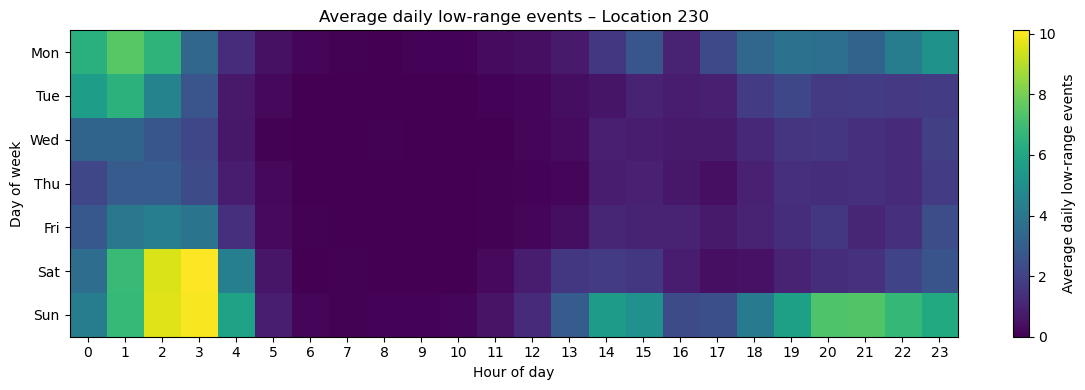

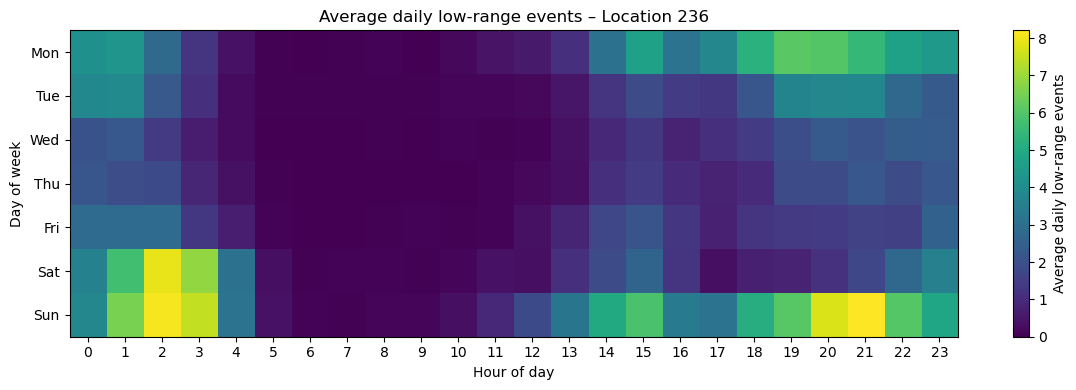

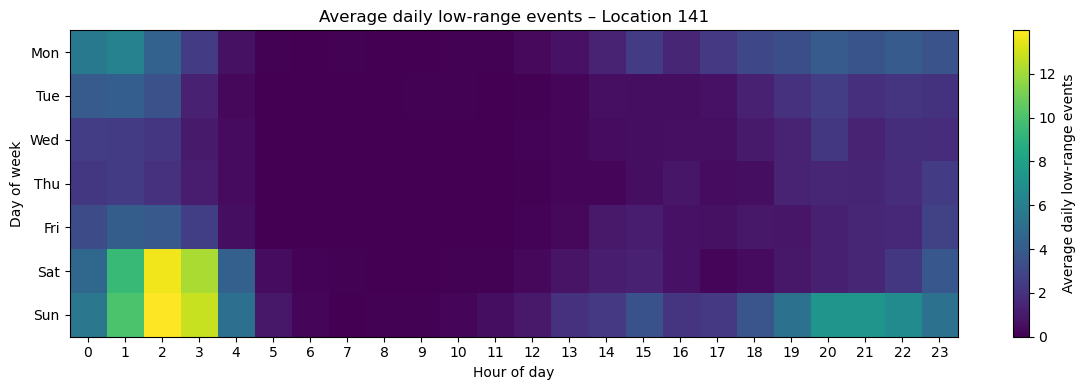

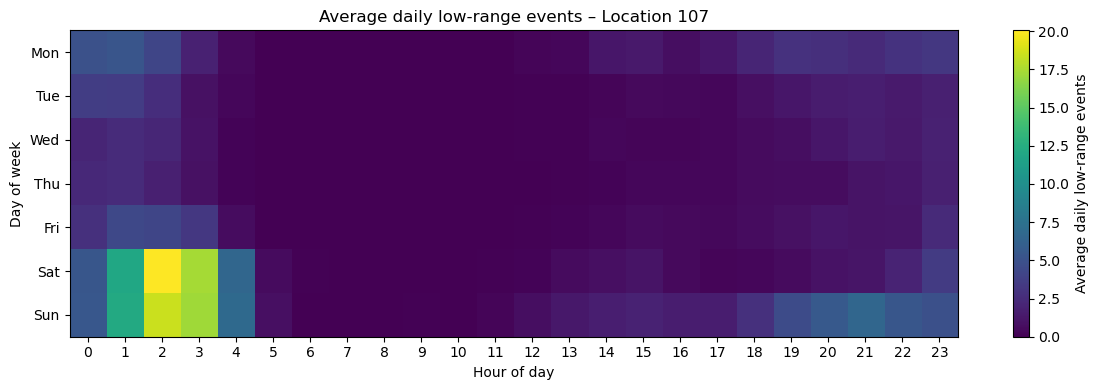

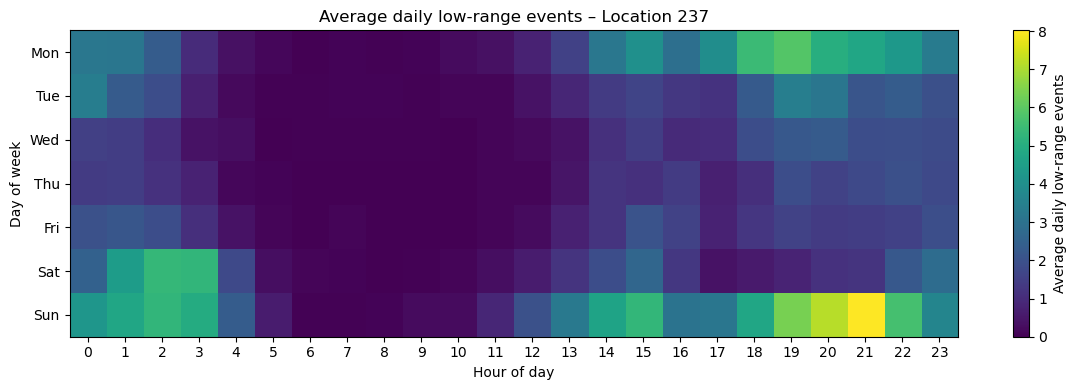

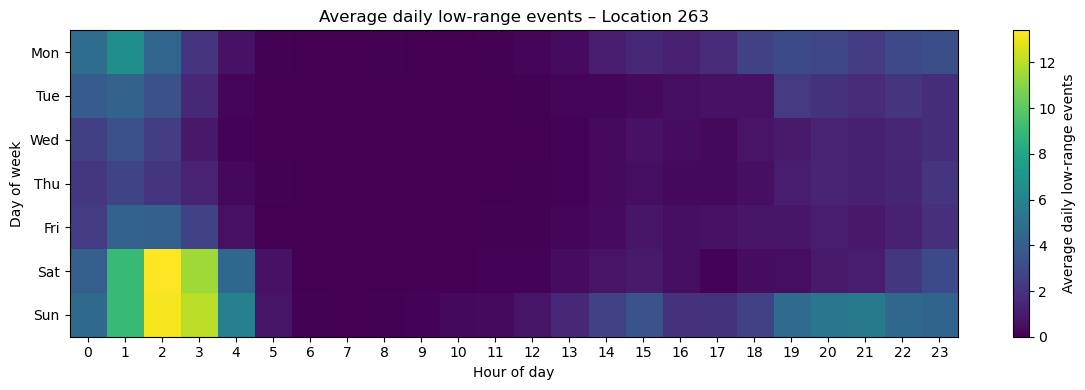

In [25]:
below_threshold_heatmaps("test_v5/test_2/", unique=False, new_threshold=20, average=True, before_min=0)

loading data...done
Below threshold rows before new threshold: 1168717
Below threshold rows after new threshold: 665686
location
79     22680
48     22311
170    18758
230    18168
68     17488
107    15403
141    15186
164    14173
263    14070
239    13699
Name: count, dtype: int64





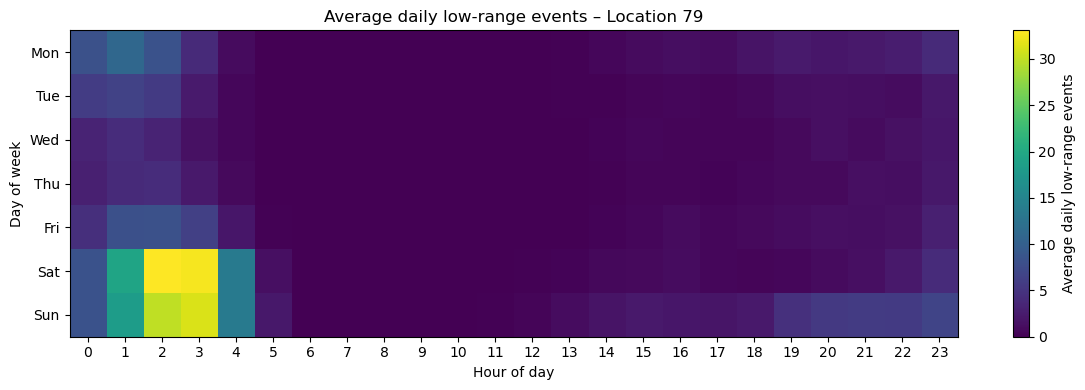

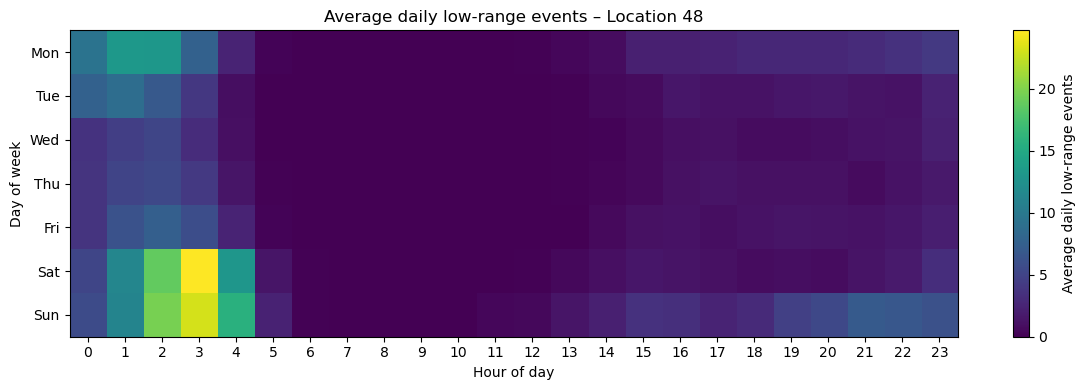

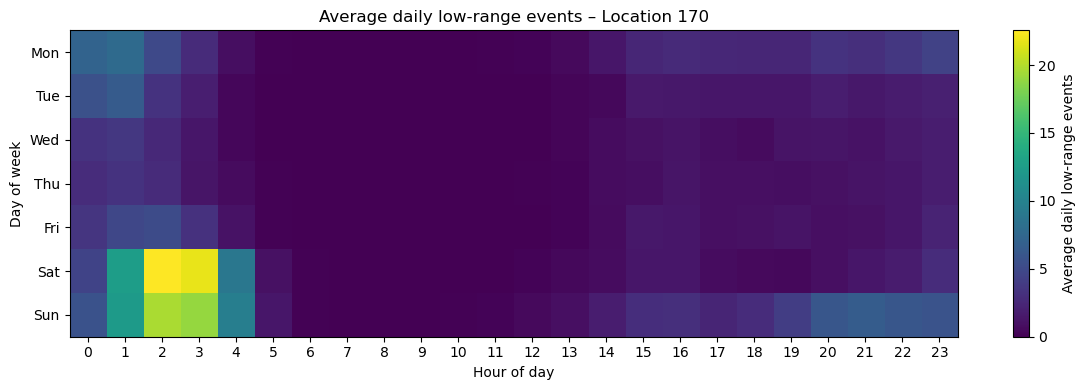

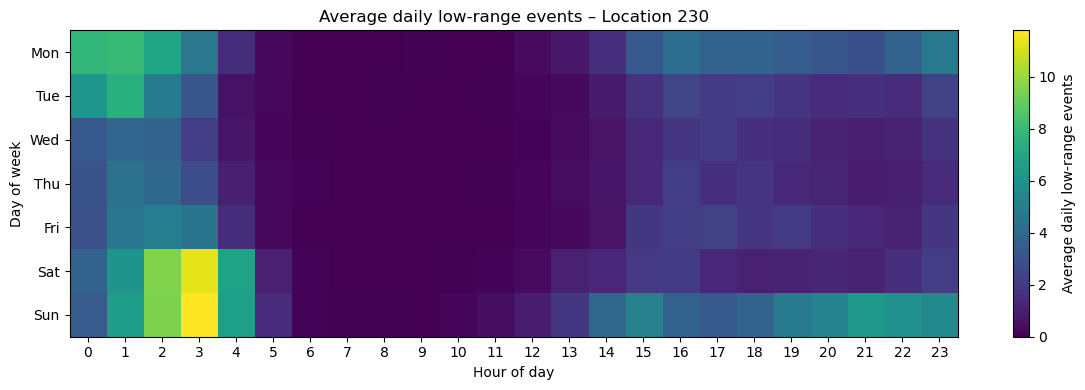

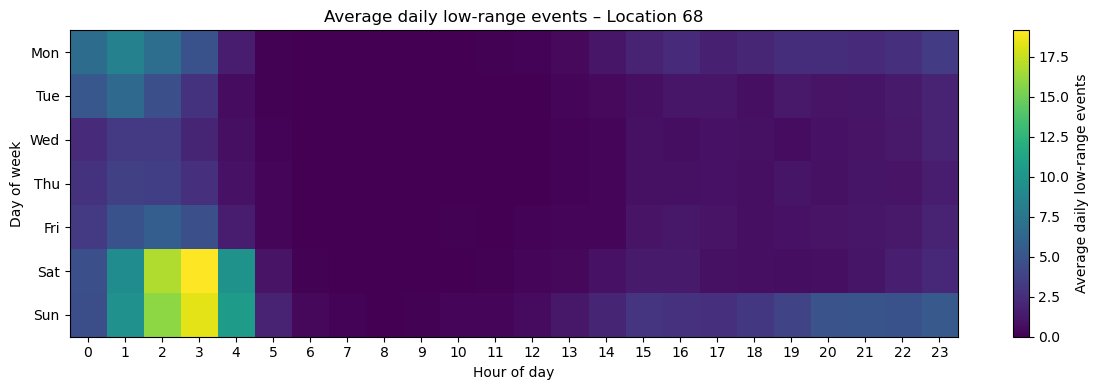

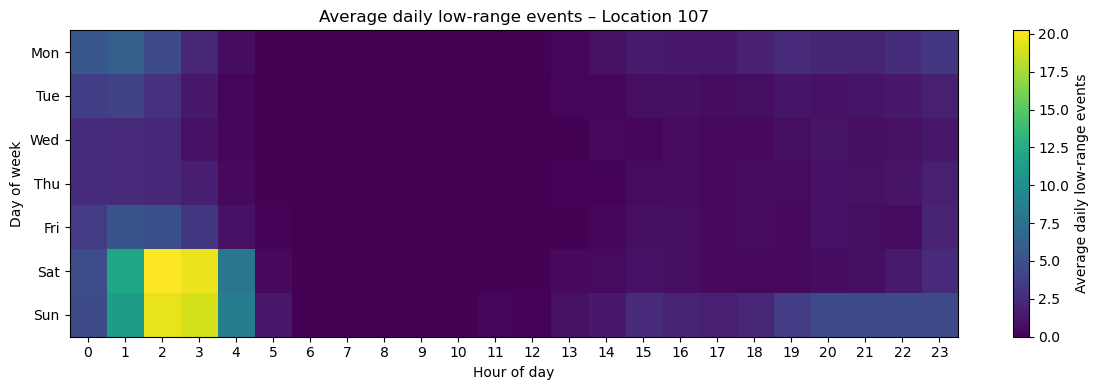

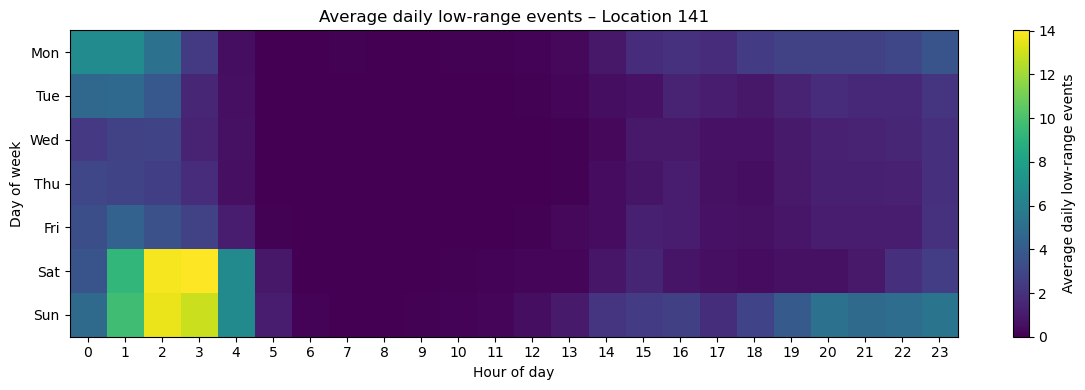

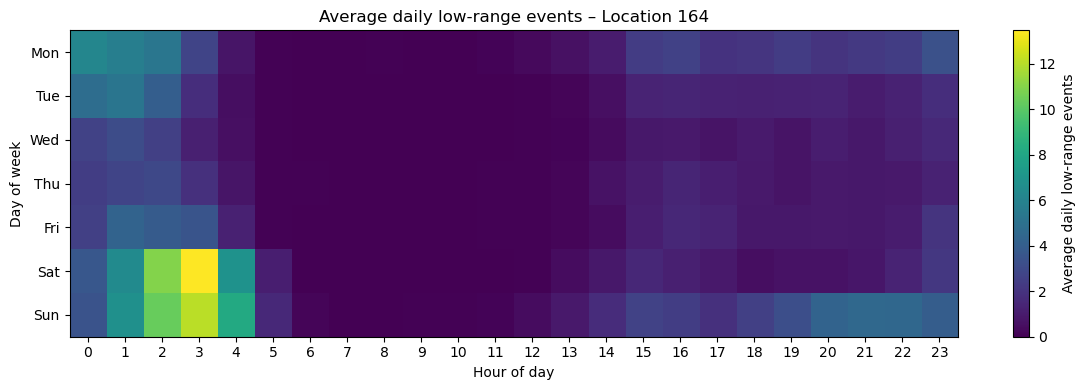

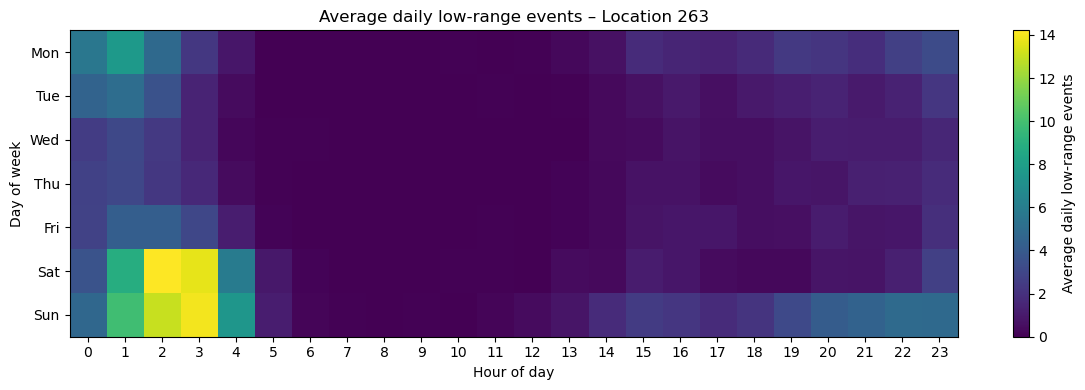

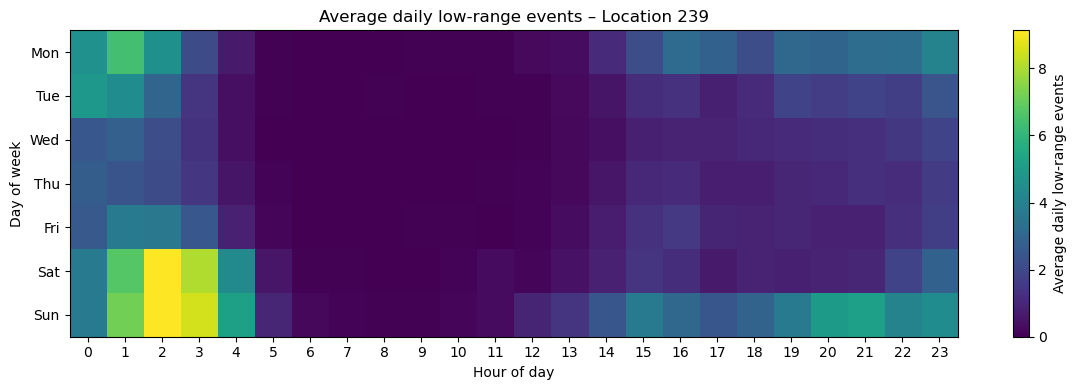

In [9]:
below_threshold_heatmaps("test_v6/test_0/", unique=False, new_threshold=20, average=True)

$$ $$

$$ $$

$$ $$

# Create a gif animation of below threshold event map over hour and day of the week

In [74]:

all_dates_2023 = pd.date_range('2023-01-01', '2023-12-31', freq='D')
n_days_per_dow = all_dates_2023.dayofweek.value_counts().sort_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
n_days_per_dow.index = dow_labels

def return_zone_count_plot(locationIDs, ax_title, sup_title=None, log_scale=False, average=True, n_days=None, v_max=100):

    if average == True and n_days == None:
        raise Exception("Average is true while n_days is None")
    
    
    counts = (
        locationIDs.dropna().value_counts()
                   .rename_axis('LocationID')
                   .rename('n')
                   .reset_index()
    )

    if average:
        counts['n'] = counts['n'] / n_days

    
    zones = gpd.read_file("data/2023 yellow taxi/taxi_zones/taxi_zones.shp")
    zones = zones.merge(counts, on='LocationID', how="left")
    zones["n"] = zones["n"].fillna(0).astype(int)

    
    # --- Lock colormap range to 0–100 and paint >100 as white ---
    #cmap = plt.cm.get_cmap("viridis").copy()
    cmap = plt.colormaps['viridis'].copy()
    cmap.set_over("white")  # anything above vmax uses this

    norm = mcolors.Normalize(vmin=0, vmax=v_max, clip=False)

    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    zones.plot(
        column="n",
        ax=ax,
        legend=True,
        linewidth=0.2,
        edgecolor="white",
        cmap=cmap,
        norm=norm,
        legend_kwds={"extend": "max"}
    )
    ax.set_title(ax_title)
    ax.set_axis_off()
    plt.tight_layout()

    if sup_title:
        fig.suptitle(sup_title, fontsize=16)
    
    pil = fig_to_pil(fig)

    return pil

def get_hour_str(hour):
    if hour == 0:
        return "12am"
    if hour / 12 >= 1:
        return f"{hour % 12}pm"
    else:
        return f"{hour}am"

def create_below_threshold_event_map_animation(test_folder, unique=False, new_threshold=None, average=False, before_min=None):
    test_folder = Path(test_folder)

    print("loading data...", end="")

    below_thres_path = test_folder / "below_thresholds.parquet"
    
    below_df = pd.read_parquet(below_thres_path)

    print("done")


    # apply before shift minimum if requested
    if before_min != None:
        below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
        
        print("Below threshold rows before new before shift minimum:", len(below_df))      
        below_df = below_df[below_df['till_end'] >= before_min]
        print("Below threshold rows after new before shift minimum:", len(below_df))

    
    # apply new threshold if requested
    if new_threshold:
        print("Below threshold rows before new threshold:", len(below_df))      
        below_df = below_df[below_df['range'] <= new_threshold]
        print("Below threshold rows after new threshold:", len(below_df))
        
    # filter out rows without unique combos
    if unique:
        print("Below threshold rows before unique filtering:", len(below_df))        
        unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Below threshold rows after unique filtering:", len(unique_below_df))



    
    # 2) Extract hour of day and day of week (0=Monday, 6=Sunday)
    below_df['hour'] = below_df['request_time'].dt.hour
    below_df['dow'] = below_df['request_time'].dt.dayofweek
    
    # Optional: map to names if you want labels later
    dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    below_df['dow_name'] = below_df['dow'].map(dict(enumerate(dow_labels)))


    sup_title = "Average number of low threshold events"

    pils = []
    
    for dow in tqdm(dow_labels):
        dow_df = below_df[below_df['dow_name'] == dow]

        curr_n_days = n_days_per_dow[dow]

        curr_max = 40

        if dow == 'Sat' or dow == 'Sun':
            curr_max = 60

        
        for hour in range(0, 24):
            hour_df = dow_df[dow_df['hour'] == hour]

            title = f"{dow} {get_hour_str(hour)}"

            pil = return_zone_count_plot(hour_df['location'], ax_title=title, sup_title=sup_title, average=average, n_days=curr_n_days, v_max=curr_max)

            pils.append(pil)

    return pils

In [23]:
pils = create_below_threshold_event_map_animation("test_v5/test_2/", unique=False, new_threshold=None, average=True, before_min=0)

loading data...done
Below threshold rows before new before shift minimum: 1362759
Below threshold rows after new before shift minimum: 1052655


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.19s/it]


In [26]:
write_mp4(pils, "test.mp4", fps=2)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


WindowsPath('test.mp4')

In [42]:
for test_num in range(5):
    curr_test = f"test_v5/test_{test_num}/"

    pils = create_below_threshold_event_map_animation(curr_test, unique=False, new_threshold=None, average=True, before_min=0)
    write_mp4(pils, f"test_{test_num}.mp4", fps=2)

loading data...done
Below threshold rows before new before shift minimum: 91623
Below threshold rows after new before shift minimum: 57333


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:55<00:00,  7.99s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


loading data...done
Below threshold rows before new before shift minimum: 390589
Below threshold rows after new before shift minimum: 275910


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.14s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


loading data...done
Below threshold rows before new before shift minimum: 1362759
Below threshold rows after new before shift minimum: 1052655


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:56<00:00,  8.09s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


loading data...done
Below threshold rows before new before shift minimum: 3494520
Below threshold rows after new before shift minimum: 2914185


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.26s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


loading data...done
Below threshold rows before new before shift minimum: 6502065
Below threshold rows after new before shift minimum: 5856301


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:58<00:00,  8.36s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
pils = create_below_threshold_event_map_animation("test_v5/test_2/", unique=False, new_threshold=None, average=True)

In [ ]:
write_mp4(pils, "test_2_updated.mp4", fps=2)

In [43]:
for test_num in range(3):
    curr_test = f"test_v6/test_{test_num}/"

    pils = create_below_threshold_event_map_animation(curr_test, unique=False, new_threshold=None, average=True, before_min=0)
    write_mp4(pils, f"test_v6_{test_num}.mp4", fps=2)

loading data...done
Below threshold rows before new before shift minimum: 1168717
Below threshold rows after new before shift minimum: 873377


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.67s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


loading data...done
Below threshold rows before new before shift minimum: 1166931
Below threshold rows after new before shift minimum: 871387


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.18s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


loading data...done
Below threshold rows before new before shift minimum: 1172266
Below threshold rows after new before shift minimum: 876386


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:57<00:00,  8.16s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (920, 990) to (928, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [27]:
no_swaps = pd.read_parquet("test_v5/test_2/below_thresholds.parquet")

no_swaps['till_end'] = (no_swaps["shift_end"] - no_swaps["request_time"]).dt.total_seconds() / 3600

print("Below threshold rows before new before shift minimum:", len(no_swaps))      
no_swaps = no_swaps[no_swaps['till_end'] >= 0]
print("Below threshold rows after new before shift minimum:", len(no_swaps))

Below threshold rows before new before shift minimum: 1362759
Below threshold rows after new before shift minimum: 1052655


In [39]:
swaps = pd.read_parquet("test_v6/test_0/below_thresholds.parquet")

swaps['till_end'] = (swaps["shift_end"] - swaps["request_time"]).dt.total_seconds() / 3600

print("Below threshold rows before new before shift minimum:", len(swaps))      
swaps = swaps[swaps['till_end'] >= 0]
print("Below threshold rows after new before shift minimum:", len(swaps))

Below threshold rows before new before shift minimum: 1168717
Below threshold rows after new before shift minimum: 873377


In [40]:
swaps = pd.read_parquet("test_v6/test_1/below_thresholds.parquet")

swaps['till_end'] = (swaps["shift_end"] - swaps["request_time"]).dt.total_seconds() / 3600

print("Below threshold rows before new before shift minimum:", len(swaps))      
swaps = swaps[swaps['till_end'] >= 0]
print("Below threshold rows after new before shift minimum:", len(swaps))

Below threshold rows before new before shift minimum: 1166931
Below threshold rows after new before shift minimum: 871387


In [41]:
swaps = pd.read_parquet("test_v6/test_2/below_thresholds.parquet")

swaps['till_end'] = (swaps["shift_end"] - swaps["request_time"]).dt.total_seconds() / 3600

print("Below threshold rows before new before shift minimum:", len(swaps))      
swaps = swaps[swaps['till_end'] >= 0]
print("Below threshold rows after new before shift minimum:", len(swaps))

Below threshold rows before new before shift minimum: 1172266
Below threshold rows after new before shift minimum: 876386


<Axes: >

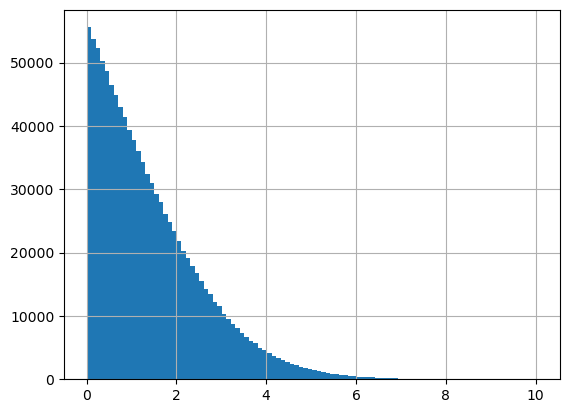

In [30]:
no_swaps['till_end'].hist(bins=100)

<Axes: >

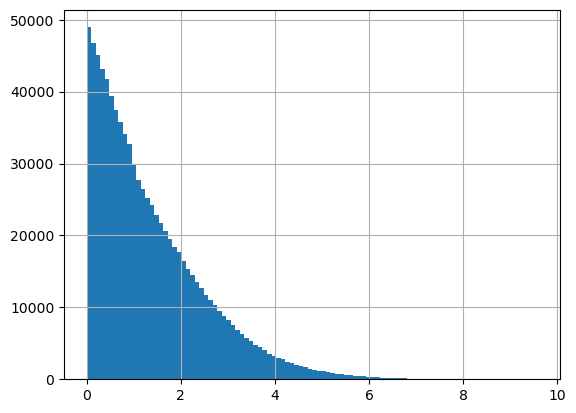

In [31]:
swaps['till_end'].hist(bins=100)

<Axes: >

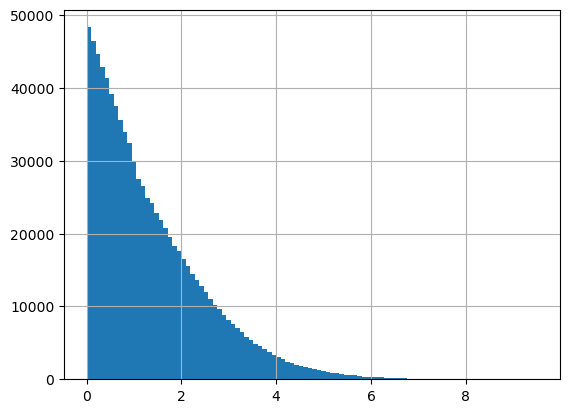

In [38]:
swaps['till_end'].hist(bins=100)

<Axes: >

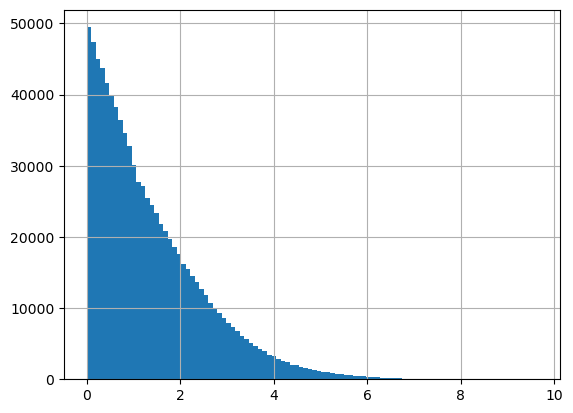

In [34]:
swaps['till_end'].hist(bins=100)

In [12]:
below_df = pd.read_parquet("test_v5/test_2/below_thresholds.parquet")

In [14]:
below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600

<Axes: >

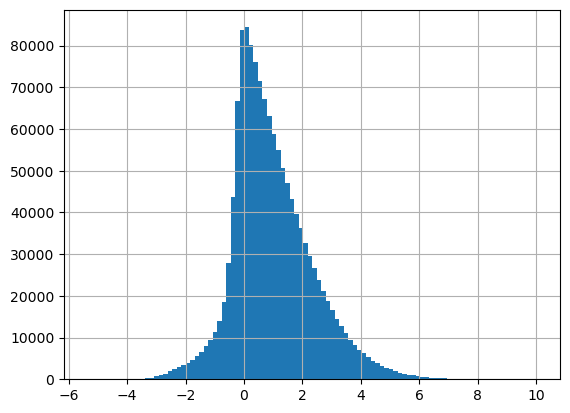

In [17]:
below_df['till_end'].hist(bins=100)

In [13]:
new_threshold = 20
before_min = 0

for num in range(5):
    folder = f"test_v5/test_{num}/"
    print(folder)

    below_df = pd.read_parquet(folder + "below_thresholds.parquet")

    below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
    
    #print("Below threshold rows before new before shift minimum:", len(below_df))      
    below_df = below_df[below_df['till_end'] >= before_min]
    #print("Below threshold rows after new before shift minimum:", len(below_df))

    #print("Below threshold rows before new threshold:", len(below_df))      
    below_df = below_df[below_df['range'] <= new_threshold]
    #print("Below threshold rows after new threshold:", len(below_df))

    #print("Below threshold rows before unique filtering:", len(below_df))        
    unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
    #print("Below threshold rows after unique filtering:", len(unique_below_df))


    print(len(unique_below_df))
    print("\n\n")

    

test_v5/test_0/
28160



test_v5/test_1/
142538



test_v5/test_2/
590716



test_v5/test_3/
1792855



test_v5/test_4/
3795414





In [172]:
before_min = 0
new_threshold = 20
unique = True

In [173]:
test_folder = Path("test_v5/test_2/")

print("loading data...", end="")

below_thres_path = test_folder / "below_thresholds.parquet"

below_df = pd.read_parquet(below_thres_path)

print("done")


# apply before shift minimum if requested
if before_min != None:
    below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
    
    print("Below threshold rows before new before shift minimum:", len(below_df))      
    below_df = below_df[below_df['till_end'] >= before_min]
    print("Below threshold rows after new before shift minimum:", len(below_df))


# apply new threshold if requested
if new_threshold:
    print("Below threshold rows before new threshold:", len(below_df))      
    below_df = below_df[below_df['range'] <= new_threshold]
    print("Below threshold rows after new threshold:", len(below_df))
    
# filter out rows without unique combos
if unique:
    print("Below threshold rows before unique filtering:", len(below_df))        
    unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
    print("Below threshold rows after unique filtering:", len(unique_below_df))




# 2) Extract hour of day and day of week (0=Monday, 6=Sunday)
below_df['hour'] = below_df['request_time'].dt.hour
below_df['dow'] = below_df['request_time'].dt.dayofweek

# Optional: map to names if you want labels later
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
below_df['dow_name'] = below_df['dow'].map(dict(enumerate(dow_labels)))


loading data...done
Below threshold rows before new before shift minimum: 1362759
Below threshold rows after new before shift minimum: 1052655
Below threshold rows before new threshold: 1052655
Below threshold rows after new threshold: 630995
Below threshold rows before unique filtering: 630995
Below threshold rows after unique filtering: 590716


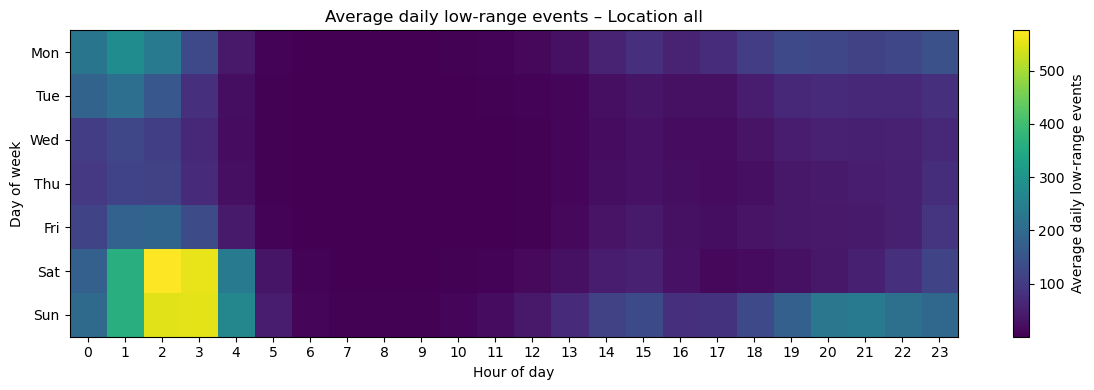

In [174]:
create_location_event_heatmap(below_df, 'all', average=True)

In [175]:
below_df

,request_time,id,location,range,shift_end,just_traveled,just_traveled_trip_distance,just_traveled_in_between_distance,till_end,hour,dow,dow_name
6,2023-01-01 09:40:03,2313.0,220,9.172104,2023-01-01 12:42:06,37.703269,23.94,13.763269,3.034167,9,6,Sun
9,2023-01-01 11:05:15,2340.0,76,5.535545,2023-01-01 11:37:24,22.103544,6.89,15.213544,0.535833,11,6,Sun
10,2023-01-01 10:13:14,2591.0,61,14.859868,2023-01-01 16:48:56,12.630758,12.36,0.270758,6.595000,10,6,Sun
17,2023-01-01 10:45:38,2444.0,162,8.370914,2023-01-01 14:26:00,36.475015,17.20,19.275015,3.672778,10,6,Sun
18,2023-01-01 10:49:51,2504.0,224,19.910014,2023-01-01 15:19:00,32.716894,17.57,15.146894,4.485833,10,6,Sun
...,...,...,...,...,...,...,...,...,...,...,...,...
1362752,2024-01-01 00:07:30,1837206.0,163,19.133077,2024-01-01 00:37:18,0.560189,0.09,0.470189,0.496667,0,0,Mon
1362755,2024-01-01 00:12:00,1837052.0,237,3.087317,2024-01-01 03:37:00,0.958300,0.82,0.138300,3.416667,0,0,Mon
1362756,2024-01-01 00:06:21,1836986.0,170,1.760784,2024-01-01 00:27:04,0.495491,0.26,0.235491,0.345278,0,0,Mon
1362757,2024-01-01 00:17:16,1836813.0,237,0.732326,2024-01-01 02:18:46,1.313088,0.30,1.013088,2.025000,0,0,Mon


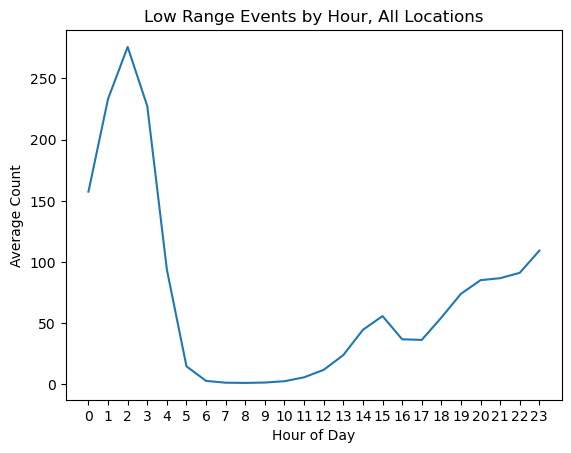

In [176]:
hour_counts = (
    below_df['hour']
    .value_counts()
    .sort_index()
    .reindex(range(24), fill_value=0)
)

hour_counts = hour_counts.div(365, axis=0)

plt.figure()
plt.plot(hour_counts.index, hour_counts.values)
plt.xlabel("Hour of Day")
plt.ylabel("Average Count")
plt.title("Low Range Events by Hour, All Locations")
plt.xticks(range(24))
plt.show()

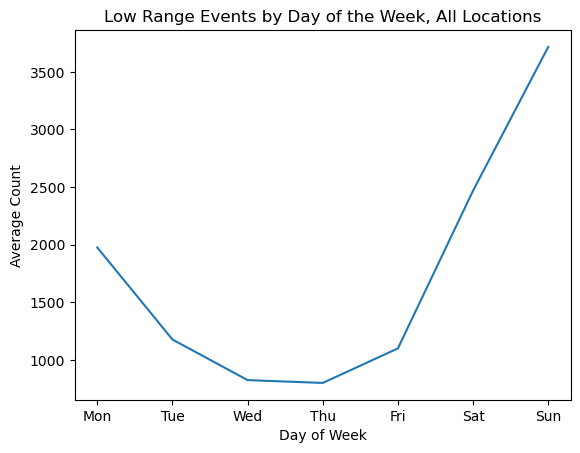

In [177]:
dow_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

dow_counts = (
    below_df['dow']
    .value_counts()
    .reindex(list(range(7)), fill_value=0)
)

dow_counts.index = dow_order

dow_counts = dow_counts.div(n_days_per_dow, axis=0)

plt.figure()
plt.plot(dow_order, dow_counts.values)
plt.xlabel("Day of Week")
plt.ylabel("Average Count")
plt.title("Low Range Events by Day of the Week, All Locations")
plt.show()

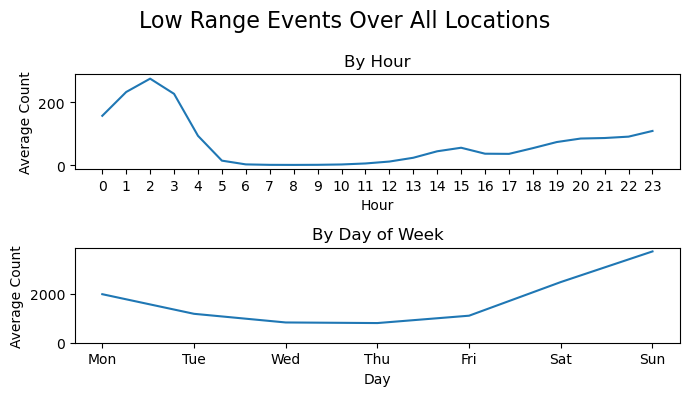

In [178]:
fig, axes = plt.subplots(2, 1, figsize=(7, 4))

# Hour plot
axes[0].plot(hour_counts.index, hour_counts.values)
axes[0].set_title("By Hour")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Average Count")
axes[0].set_xticks(range(24))

# DOW plot
axes[1].plot(dow_labels, dow_counts.values)
axes[1].set_title("By Day of Week")
axes[1].set_xlabel("Day")
axes[1].set_ylim(0)
axes[1].set_ylabel("Average Count")

fig.suptitle("Low Range Events Over All Locations" , fontsize=16)

plt.tight_layout()

plt.savefig("test_2_lines.jpg", bbox_inches='tight', dpi=300)

plt.show()

In [179]:
test_2_dow_counts = dow_counts.copy()
test_2_hour_counts = hour_counts.copy()

In [48]:
dow_counts

Mon    102717
Tue     61201
Wed     42881
Thu     41615
Fri     57208
Sat    128404
Sun    196969
Name: count, dtype: int64

In [40]:
dow_counts.index

Index([6, 5, 0, 1, 4, 2, 3], dtype='int32', name='dow')

In [43]:
dow_counts.reindex(dow_order)

dow
Mon   NaN
Tue   NaN
Wed   NaN
Thu   NaN
Fri   NaN
Sat   NaN
Sun   NaN
Name: count, dtype: float64

In [ ]:
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    heatmap_data = (
        loc_df
        .groupby(['dow_name', 'hour'])
        .size()
        .unstack(fill_value=0)
        .reindex(dow_labels)  # ensure Mon→Sun order
    )

    # divide by number of days of week if average
    if average:        
        # --- Convert counts to average events per day-of-week ---
        # Divide each dow row by the number of such days in 2023
        heatmap_data = heatmap_data.div(n_days_per_dow, axis=0)

    # 5) Plot with matplotlib
    plt.figure(figsize=(12, 4))
    im = plt.imshow(heatmap_data, aspect='auto')
    
    plt.xticks(range(24), range(24))               # hours 0–23
    plt.yticks(range(len(dow_labels)), dow_labels) # Mon–Sun
    
    cbar = plt.colorbar(im)

    if average:
        cbar.set_label('Average daily low-range events')
        plt.title(f'Average daily low-range events – Location {loc_id}')

    else:
        cbar.set_label('Count of low-range events')
        plt.title(f'Low-range events – Location {loc_id}')
    
    plt.xlabel('Hour of day')
    plt.ylabel('Day of week')
    plt.tight_layout()
    plt.show()

In [71]:
below_df

,request_time,id,location,range,shift_end,just_traveled,just_traveled_trip_distance,just_traveled_in_between_distance,till_end,hour,dow,dow_name
6,2023-01-01 09:40:03,2313.0,220,9.172104,2023-01-01 12:42:06,37.703269,23.94,13.763269,3.034167,9,6,Sun
9,2023-01-01 11:05:15,2340.0,76,5.535545,2023-01-01 11:37:24,22.103544,6.89,15.213544,0.535833,11,6,Sun
10,2023-01-01 10:13:14,2591.0,61,14.859868,2023-01-01 16:48:56,12.630758,12.36,0.270758,6.595000,10,6,Sun
17,2023-01-01 10:45:38,2444.0,162,8.370914,2023-01-01 14:26:00,36.475015,17.20,19.275015,3.672778,10,6,Sun
18,2023-01-01 10:49:51,2504.0,224,19.910014,2023-01-01 15:19:00,32.716894,17.57,15.146894,4.485833,10,6,Sun
...,...,...,...,...,...,...,...,...,...,...,...,...
1362752,2024-01-01 00:07:30,1837206.0,163,19.133077,2024-01-01 00:37:18,0.560189,0.09,0.470189,0.496667,0,0,Mon
1362755,2024-01-01 00:12:00,1837052.0,237,3.087317,2024-01-01 03:37:00,0.958300,0.82,0.138300,3.416667,0,0,Mon
1362756,2024-01-01 00:06:21,1836986.0,170,1.760784,2024-01-01 00:27:04,0.495491,0.26,0.235491,0.345278,0,0,Mon
1362757,2024-01-01 00:17:16,1836813.0,237,0.732326,2024-01-01 02:18:46,1.313088,0.30,1.013088,2.025000,0,0,Mon


In [180]:
dow = 'Mon'
hour = 15

In [181]:
# 2) Extract hour of day and day of week (0=Monday, 6=Sunday)
below_df['hour'] = below_df['request_time'].dt.hour
below_df['dow'] = below_df['request_time'].dt.dayofweek

# Optional: map to names if you want labels later
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
below_df['dow_name'] = below_df['dow'].map(dict(enumerate(dow_labels)))


sup_title = "Average number of low threshold events, range < 20"

dow_df = below_df[below_df['dow_name'] == dow]

curr_n_days = n_days_per_dow[dow]

hour_df = dow_df[dow_df['hour'] == hour]


curr_max = 5

title = f"Monday 3pm"

highlight_locations = [237, 236, 161, 132, 138]

pil = return_zone_count_plot_v2(hour_df['location'], ax_title=title, sup_title=sup_title, average=True, n_days=curr_n_days, v_max=curr_max, highlight_locations=None, highlight_size=20)

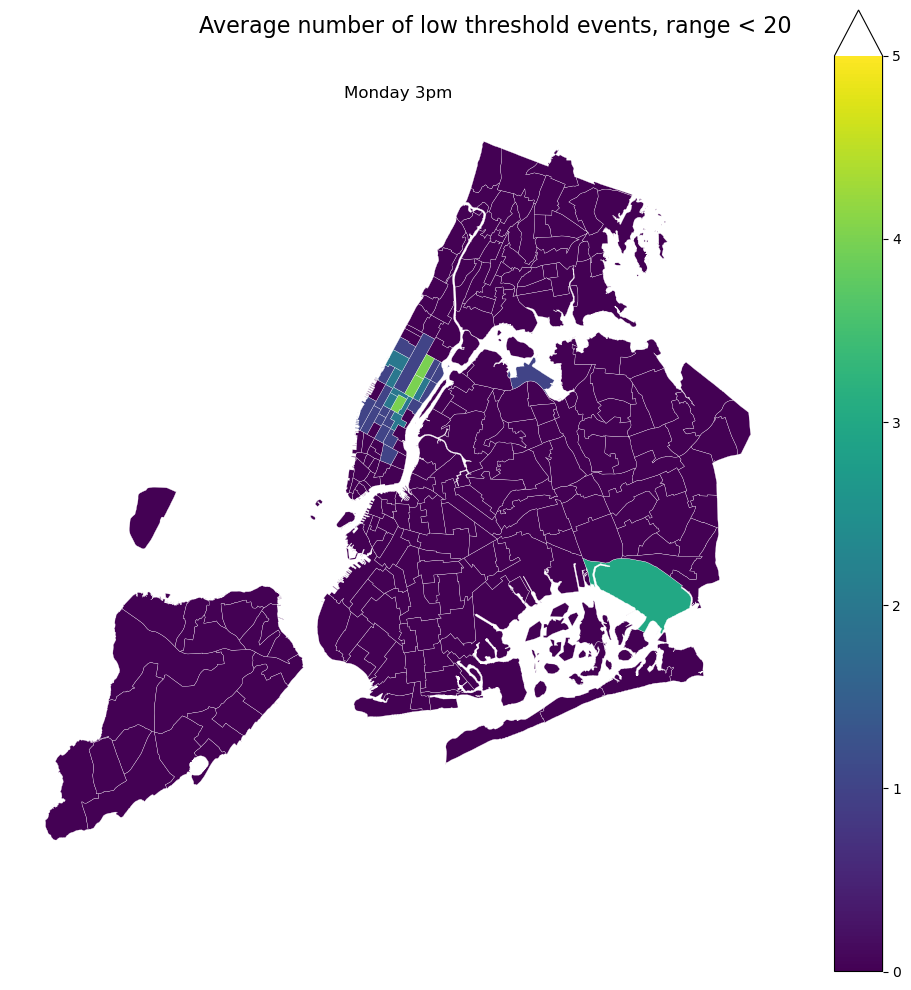

In [182]:
pil

In [184]:
def return_zone_count_plot_v2(locationIDs, ax_title, sup_title=None, log_scale=False, average=True, n_days=None, v_max=100, highlight_locations=None, highlight_size=40):

    if average == True and n_days == None:
        raise Exception("Average is true while n_days is None")
    
    
    counts = (
        locationIDs.dropna().value_counts()
                   .rename_axis('LocationID')
                   .rename('n')
                   .reset_index()
    )

    if average:
        counts['n'] = counts['n'] / n_days

    
    zones = gpd.read_file("data/2023 yellow taxi/taxi_zones/taxi_zones.shp")
    zones = zones.merge(counts, on='LocationID', how="left")
    zones["n"] = zones["n"].fillna(0).astype(int)

    
    # --- Lock colormap range to 0–100 and paint >100 as white ---
    #cmap = plt.cm.get_cmap("viridis").copy()
    cmap = plt.colormaps['viridis'].copy()
    cmap.set_over("white")  # anything above vmax uses this

    norm = mcolors.Normalize(vmin=0, vmax=v_max, clip=False)

    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    zones.plot(
        column="n",
        ax=ax,
        legend=True,
        linewidth=0.2,
        edgecolor="white",
        cmap=cmap,
        norm=norm,
        legend_kwds={"extend": "max"}
    )

    # --- add the red dot ---
    if highlight_locations:
        for highlight_locationID in highlight_locations:
            sel = zones.loc[zones["LocationID"] == highlight_locationID]
            if not sel.empty:
                # representative_point is inside the polygon
                pt = sel.geometry.representative_point().iloc[0]
                ax.scatter(pt.x, pt.y, color="red", s=highlight_size, zorder=10)
    
                # optional label:
                # ax.annotate(str(highlight_locationID), (pt.x, pt.y),
                #             xytext=(3, 3), textcoords="offset points",
                #             color="red", fontsize=9, weight="bold")
    
    ax.set_title(ax_title)
    ax.set_axis_off()
    plt.tight_layout()

    if sup_title:
        fig.suptitle(sup_title, fontsize=16)

    #plt.savefig("test_2_heatmap_export.jpg", bbox_inches='tight', dpi=300)
    plt.savefig("test_6_heatmap_export.jpg", bbox_inches='tight', dpi=300)
    
    pil = fig_to_pil(fig)

    return pil

In [155]:
new_threshold = 20
before_min = 0

for num in range(3):
    folder = f"test_v6/test_{num}/"
    print(folder)

    below_df = pd.read_parquet(folder + "below_thresholds.parquet")

    below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
    
    #print("Below threshold rows before new before shift minimum:", len(below_df))      
    below_df = below_df[below_df['till_end'] >= before_min]
    #print("Below threshold rows after new before shift minimum:", len(below_df))

    #print("Below threshold rows before new threshold:", len(below_df))      
    below_df = below_df[below_df['range'] <= new_threshold]
    #print("Below threshold rows after new threshold:", len(below_df))

    #print("Below threshold rows before unique filtering:", len(below_df))        
    unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
    #print("Below threshold rows after unique filtering:", len(unique_below_df))


    print(len(unique_below_df))
    print((590_716 - len(unique_below_df)) / 590_716)
    print("\n\n")


test_v6/test_0/
461393
0.2189258459225753



test_v6/test_1/
459688
0.22181217370106784



test_v6/test_2/
463564
0.21525064497999039





In [162]:
150 * 0.3

45.0

In [185]:
before_min = 0
new_threshold = 20
unique = True

In [186]:
test_folder = Path("test_v6/test_1/")

print("loading data...", end="")

below_thres_path = test_folder / "below_thresholds.parquet"

below_df = pd.read_parquet(below_thres_path)

print("done")


# apply before shift minimum if requested
if before_min != None:
    below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
    
    print("Below threshold rows before new before shift minimum:", len(below_df))      
    below_df = below_df[below_df['till_end'] >= before_min]
    print("Below threshold rows after new before shift minimum:", len(below_df))


# apply new threshold if requested
if new_threshold:
    print("Below threshold rows before new threshold:", len(below_df))      
    below_df = below_df[below_df['range'] <= new_threshold]
    print("Below threshold rows after new threshold:", len(below_df))
    
# filter out rows without unique combos
if unique:
    print("Below threshold rows before unique filtering:", len(below_df))        
    unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
    print("Below threshold rows after unique filtering:", len(unique_below_df))




# 2) Extract hour of day and day of week (0=Monday, 6=Sunday)
below_df['hour'] = below_df['request_time'].dt.hour
below_df['dow'] = below_df['request_time'].dt.dayofweek

# Optional: map to names if you want labels later
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
below_df['dow_name'] = below_df['dow'].map(dict(enumerate(dow_labels)))

loading data...done
Below threshold rows before new before shift minimum: 1166931
Below threshold rows after new before shift minimum: 871387
Below threshold rows before new threshold: 871387
Below threshold rows after new threshold: 485442
Below threshold rows before unique filtering: 485442
Below threshold rows after unique filtering: 459688


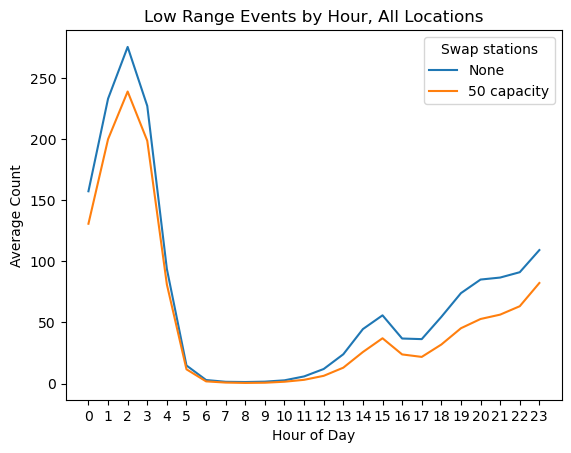

In [195]:
hour_counts = (
    below_df['hour']
    .value_counts()
    .sort_index()
    .reindex(range(24), fill_value=0)
)

hour_counts = hour_counts.div(365, axis=0)

plt.figure()
plt.plot(test_2_hour_counts.index, test_2_hour_counts.values, label='None')
plt.plot(hour_counts.index, hour_counts.values, label='50 capacity')
plt.xlabel("Hour of Day")
plt.ylabel("Average Count")
plt.title("Low Range Events by Hour, All Locations")
plt.xticks(range(24))
plt.legend(title="Swap stations")
plt.show()

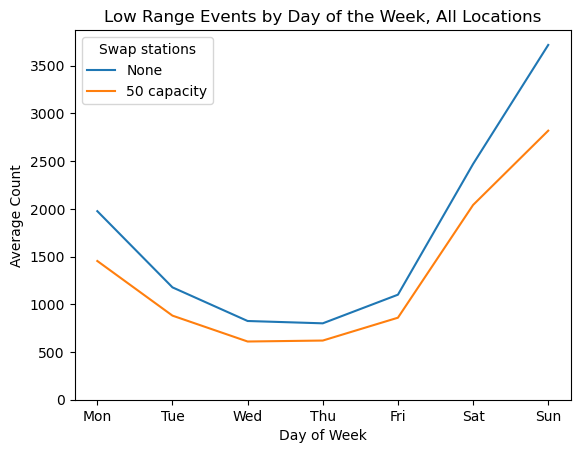

In [199]:
dow_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

dow_counts = (
    below_df['dow']
    .value_counts()
    .reindex(list(range(7)), fill_value=0)
)

dow_counts.index = dow_order

dow_counts = dow_counts.div(n_days_per_dow, axis=0)

plt.figure()
plt.plot(dow_order, test_2_dow_counts.values, label='None')
plt.plot(dow_order, dow_counts.values, label='50 capacity')
plt.xlabel("Day of Week")
plt.ylabel("Average Count")
plt.legend(title="Swap stations")
plt.title("Low Range Events by Day of the Week, All Locations")
plt.ylim(0)
plt.show()

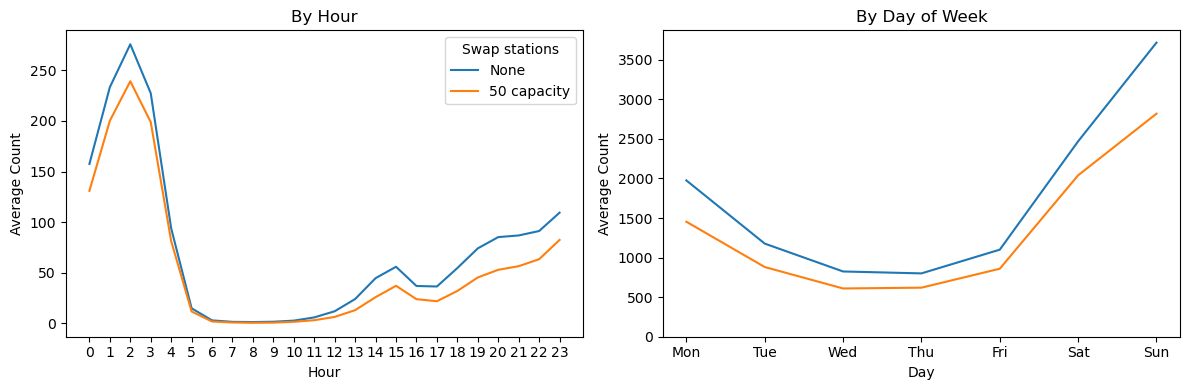

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Hour plot
axes[0].plot(test_2_hour_counts.index, test_2_hour_counts.values, label='None')
axes[0].plot(hour_counts.index, hour_counts.values, label='50 capacity')
axes[0].set_title("By Hour")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Average Count")
axes[0].legend(title="Swap stations")
axes[0].set_xticks(range(24))

# DOW plot
axes[1].plot(dow_order, test_2_dow_counts.values, label='None')
axes[1].plot(dow_order, dow_counts.values, label='50 capacity')
axes[1].set_title("By Day of Week")
axes[1].set_xlabel("Day")
axes[1].set_ylim(0)
axes[0].legend(title="Swap stations")
axes[1].set_ylabel("Average Count")

#fig.suptitle("Low Range Events Over All Locations" , fontsize=16)

plt.tight_layout()

plt.savefig("test_6_lines.jpg", bbox_inches='tight', dpi=300)

plt.show()

In [189]:
dow = 'Mon'
hour = 15

In [190]:
# 2) Extract hour of day and day of week (0=Monday, 6=Sunday)
below_df['hour'] = below_df['request_time'].dt.hour
below_df['dow'] = below_df['request_time'].dt.dayofweek

# Optional: map to names if you want labels later
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
below_df['dow_name'] = below_df['dow'].map(dict(enumerate(dow_labels)))


sup_title = "Average number of low threshold events, range < 20"

dow_df = below_df[below_df['dow_name'] == dow]

curr_n_days = n_days_per_dow[dow]

hour_df = dow_df[dow_df['hour'] == hour]


curr_max = 5

title = f"Monday 3pm"

highlight_locations = [237, 236, 161, 132, 138]

pil = return_zone_count_plot_v2(hour_df['location'], ax_title=title, sup_title=sup_title, average=True, n_days=curr_n_days, v_max=curr_max, highlight_locations=highlight_locations, highlight_size=20)

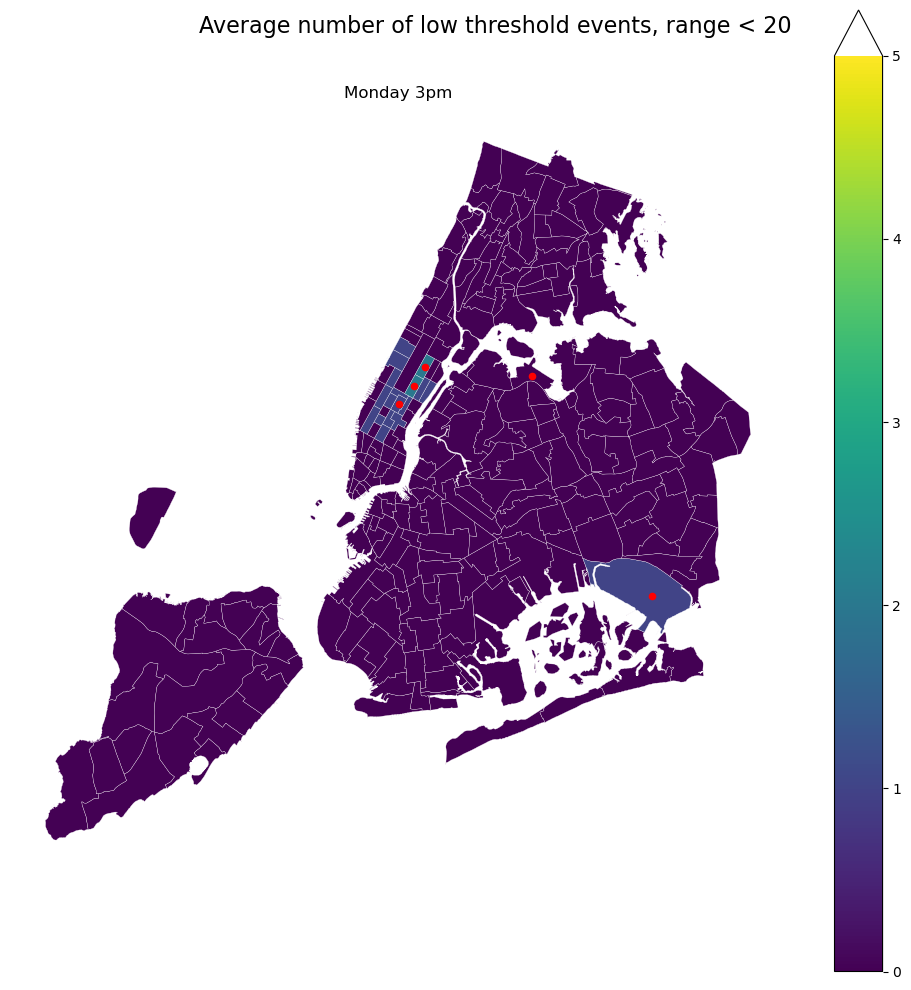

In [191]:
pil

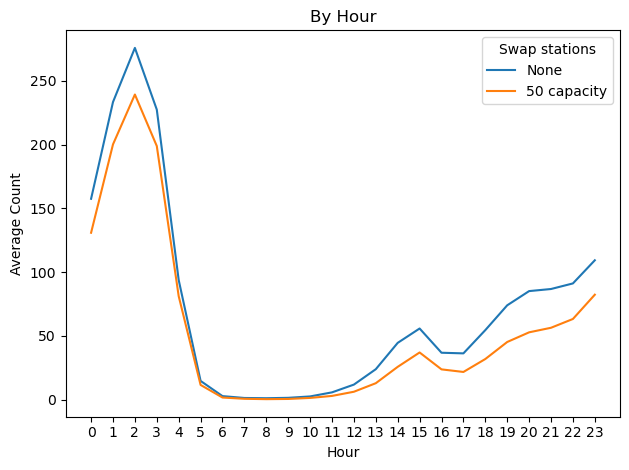

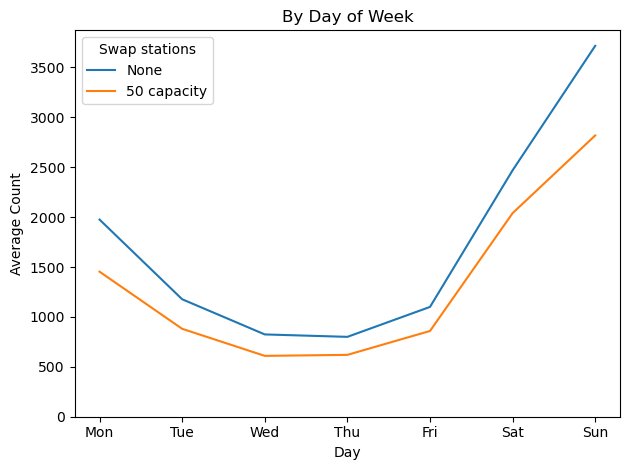

In [211]:
# Hour plot
plt.plot(test_2_hour_counts.index, test_2_hour_counts.values, label='None')
plt.plot(hour_counts.index, hour_counts.values, label='50 capacity')
plt.title("By Hour")
plt.xlabel("Hour")
plt.ylabel("Average Count")
plt.legend(title="Swap stations")
plt.xticks(range(24))

plt.tight_layout()

plt.savefig("test_6_hour_lines.jpg", bbox_inches='tight', dpi=300)

plt.show()




# DOW plot
plt.plot(dow_order, test_2_dow_counts.values, label='None')
plt.plot(dow_order, dow_counts.values, label='50 capacity')
plt.title("By Day of Week")
plt.xlabel("Day")
plt.ylim(0)
plt.legend(title="Swap stations")
plt.ylabel("Average Count")

plt.tight_layout()

plt.savefig("test_6_dow_lines.jpg", bbox_inches='tight', dpi=300)

plt.show()


In [268]:
below_df = pd.read_parquet("test_v6/test_1/below_thresholds.parquet")

In [269]:
before_min = None
new_threshold = 20
unique = True

In [270]:
# apply before shift minimum if requested
if before_min != None:
    below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600
    
    print("Below threshold rows before new before shift minimum:", len(below_df))      
    below_df = below_df[below_df['till_end'] >= before_min]
    print("Below threshold rows after new before shift minimum:", len(below_df))


# apply new threshold if requested
if new_threshold:
    print("Below threshold rows before new threshold:", len(below_df))      
    below_df = below_df[below_df['range'] <= new_threshold]
    print("Below threshold rows after new threshold:", len(below_df))
    
# filter out rows without unique combos
if unique:
    print("Below threshold rows before unique filtering:", len(below_df))        
    below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id"], keep="first"))
    print("Below threshold rows after unique filtering:", len(below_df))

Below threshold rows before new threshold: 1166931
Below threshold rows after new threshold: 664376
Below threshold rows before unique filtering: 664376
Below threshold rows after unique filtering: 291415


In [271]:
below_df['till_end'] = (below_df["shift_end"] - below_df["request_time"]).dt.total_seconds() / 3600

In [267]:
no_swaps = below_df[below_df['just_traveled_in_between_distance'] < 10]['till_end'].to_numpy()

In [272]:
with_swaps = below_df[below_df['just_traveled_in_between_distance'] < 10]['till_end'].to_numpy()

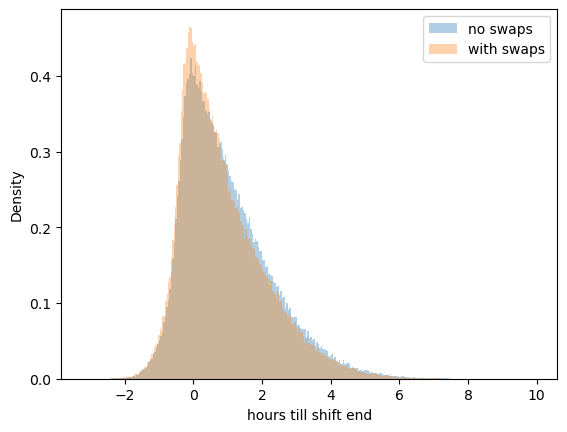

In [275]:
plt.hist(no_swaps,  bins=300, density=True, alpha=0.35, label="no swaps")
plt.hist(with_swaps, bins=300, density=True, alpha=0.35, label="with swaps")
plt.xlabel("hours till shift end")
plt.ylabel("Density")
plt.legend(loc='upper right')

#plt.savefig("gt_vs_sim_hist.jpg", dpi=300, bbox_inches="tight")

plt.show()

In [276]:
shift_durations = pd.read_pickle("data/sim_info/shift_arrays.pkl")